In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
from dataclasses import dataclass
from pathlib import Path
import yaml

from omegaconf import OmegaConf, DictConfig
import pandas as pd
from matplotlib import transforms
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.analysis.trf import coefs_to_df
from src.encoding.ecog.timit import OutFile
from src.encoding.ecog import timit as timit_encoding, get_electrode_df, \
     AlignedECoGDataset, ContrastiveModelSnapshot, epoch_by_state_space
from src.viz.epoching import plot_epoch_raster

In [90]:
dataset = "timit"
subject = "EC212"
ttest_results_path = f"outputs/encoder_comparison_across_subjects/{dataset}/ttest.csv"
scores_path = f"outputs/encoder_comparison_across_subjects/{dataset}/scores.csv"
encoder_dirs = list(Path("outputs/encoders").glob(f"{dataset}/*/{subject}"))

pval_threshold = 1e-3

In [91]:
scores_df = pd.read_csv(scores_path, index_col=["dataset", "subject", "model2", "model1"]).loc[dataset, subject]
scores_df

/tmp/ipykernel_3476946/1227382919.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  scores_df = pd.read_csv(scores_path, index_col=["dataset", "subject", "model2", "model1"]).loc[dataset, subject]


electrode_name  \
model2                             model1                    
phoneme                            baseline            SG1   
                                   baseline            SG1   
                                   baseline            SG1   
                                   baseline            SG2   
                                   baseline            SG2   
...                                                    ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline          PG127   
                                   baseline          PG127   
                                   baseline          PG128   
                                   baseline          PG128   
                                   baseline          PG128   

                                                                          model  \
model2                             model1                                         
phoneme                            baseline                            baseline   
                                   baseline                            baseline   
                                   baseline                            baseline   
                                   baseline                            baseline   
                                   baseline                            baseline   
...                                                                         ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   

                                             output_dim  fold     score  \
model2                             model1                                 
phoneme                            baseline           0     0  0.000318   
                                   baseline           0     1 -0.000303   
                                   baseline           0     2  0.001780   
                                   baseline           1     0  0.003573   
                                   baseline           1     1  0.000343   
...                                                 ...   ...       ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline         382     1 -0.002652   
                                   baseline         382     2 -0.000572   
                                   baseline         383     0 -0.003322   
                                   baseline         383     1 -0.002038   
                                   baseline         383     2 -0.002451   

                                                output_name  
model2                             model1                    
phoneme                            baseline      (0, 'SG1')  
                                   baseline      (0, 'SG1')  
                                   baseline      (0, 'SG1')  
                                   baseline      (1, 'SG2')  
                                   baseline      (1, 'SG2')  
...                                                     ...  
word_broad-aniso3-w2v2_8-meanlast5 baseline  (382, 'PG127')  
                                   baseline  (382, 'PG127')  
                                   baseline  (383, 'PG128')  
                                   baseline  (383, 'PG128')  
                                   baseline  (383, 'PG128')  

[50688 rows x 6 columns]

In [92]:
ttest_df = pd.read_csv(ttest_results_path, index_col=["dataset", "subject", "model2", "model1", "output_dim"]).loc[dataset, subject]
ttest_df["log_pval"] = np.log10(ttest_df["pval"])
ttest_df

/tmp/ipykernel_3476946/294281794.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ttest_df = pd.read_csv(ttest_results_path, index_col=["dataset", "subject", "model2", "model1", "output_dim"]).loc[dataset, subject]


Unnamed: 4  \
model2                             model1   output_dim               
phoneme                            baseline 201                  0   
                                            190                  1   
                                            158                  2   
                                            206                  3   
                                            231                  4   
...                                                            ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 81                  87   
                                            358                 88   
                                            263                 89   
                                            203                 90   
                                            17                  91   

                                                       permutation  \
model2                             model1   output_dim               
phoneme                            baseline 201              shift   
                                            190              shift   
                                            158              shift   
                                            206              shift   
                                            231              shift   
...                                                            ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 81               shift   
                                            358              shift   
                                            263              units   
                                            203              shift   
                                            17               units   

                                                               tval  \
model2                             model1   output_dim                
phoneme                            baseline 201         1051.367209   
                                            190          318.343472   
                                            158          139.735324   
                                            206           95.169620   
                                            231           82.908127   
...                                                             ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 81             1.729592   
                                            358            1.488176   
                                            263            1.472680   
                                            203            0.730855   
                                            17             0.542919   

                                                                pval  \
model2                             model1   output_dim                 
phoneme                            baseline 201         4.910559e-12   
                                            190         5.841695e-10   
                                            158         1.573179e-08   
                                            206         7.308669e-08   
                                            231         1.268650e-07   
...                                                              ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 81          1.587583e-01   
                                            358         2.109265e-01   
                                            263         2.148251e-01   
                                            203         5.053746e-01   
                                            17          6.160228e-01   

                                                         log_pval  
model2                             model1   output_dim             
phoneme                            baseline 201        -11.308869  
                                            190         -9.233461  
                                            158         -7.803222  
                                 

In [93]:
ttest_filtered_df = ttest_df.dropna().sort_values("pval", ascending=False) \
    .groupby(["model2", "output_dim"]).first()
ttest_filtered_df = ttest_filtered_df.loc[ttest_filtered_df["pval"] < pval_threshold]
ttest_filtered_df

Unnamed: 4 permutation       tval          pval  \
model2            output_dim                                                    
biphone_pred      0                   27       shift   8.794796  9.219634e-04   
                  157                 12       shift  25.347666  1.438489e-05   
                  174                  2       shift  90.538906  8.921896e-08   
                  184                  7       shift  53.815093  7.137330e-07   
                  186                 11       shift  25.543281  1.395147e-05   
...                                  ...         ...        ...           ...   
word_broad-w2v2_8 221                 21       units  17.006624  7.010258e-05   
                  230                 36       units  10.876547  4.056025e-04   
                  233                 27       units  14.344642  1.372307e-04   
                  234                 42       units   9.310010  7.407374e-04   
                  236                 43       shift   9.167557  7.860479e-04   

                              log_pval  
model2            output_dim            
biphone_pred      0          -3.035286  
                  157        -4.842094  
                  174        -7.049543  
                  184        -6.146464  
                  186        -4.855380  
...                                ...  
word_broad-w2v2_8 221        -4.154266  
                  230        -3.391899  
                  233        -3.862549  
                  234        -3.130336  
                  236        -3.104551  

[457 rows x 5 columns]

In [94]:
encoder_dirs = [Path(p) for p in encoder_dirs]
encoder_dirs = {encoder_dir.parent.name: encoder_dir for encoder_dir in encoder_dirs}
encoders = {model_name: torch.load(encoder_dir / "model.pkl")
            for model_name, encoder_dir in encoder_dirs.items()}
encoder_names = sorted(encoders.keys())

In [95]:
baseline_scores = pd.read_csv(encoder_dirs["baseline"] / "scores.csv")

In [96]:
# Just need a random config in order to extract relevant paths and get outfile
sample_model_path = encoder_dirs["phoneme"]
with (sample_model_path / ".hydra" / "config.yaml").open() as f:
    model_config = OmegaConf.create(yaml.safe_load(f))
out = timit_encoding.prepare_out_file(model_config, next(iter(model_config.data)))

In [97]:
snapshot = ContrastiveModelSnapshot.from_config(model_config, next(iter(model_config.feature_sets.model_features.values())))

In [98]:
aligned = AlignedECoGDataset(snapshot, out)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

In [99]:
electrode_df = pd.read_csv(next(iter(encoder_dirs.values())) / "electrodes.csv")
electrode_df

electrode_idx electrode_name      long_name   type              roi
0                0            SG1  SuperiorGrid1   grid  parsopercularis
1                1            SG2  SuperiorGrid2   grid  parsopercularis
2                2            SG3  SuperiorGrid3   grid  parsopercularis
3                3            SG4  SuperiorGrid4   grid  parsopercularis
4                4            SG5  SuperiorGrid5   grid  parsopercularis
..             ...            ...            ...    ...              ...
459            459            EKG            EKG    EKG               []
460            460            REF      Reference  strip               []
461            461            REF      Reference  strip               []
462            462            REF      Reference  strip               []
463            463            REF      Reference  strip               []

[464 rows x 5 columns]

In [100]:
num_fit_electrodes = next(iter(encoders.values())).coef_.shape[0]
electrode_names = electrode_df.head(num_fit_electrodes).electrode_name
coef_dfs = {model_name: coefs_to_df(torch.load(encoder_dir / "coefs.pkl"),
                                    encoders[model_name].feature_names,
                                    electrode_names,
                                    encoders[model_name].sfreq)
            for model_name, encoder_dir in tqdm(encoder_dirs.items())}
coef_df = pd.concat(coef_dfs, names=["model"]).droplevel(1)
coef_df

  0%|          | 0/23 [00:00<?, ?it/s]

fold            feature output_name  input_dim  \
model                                                                  
biphone_recon-w2v2_8     0              onset         SG1          0   
biphone_recon-w2v2_8     0              onset         SG1          0   
biphone_recon-w2v2_8     0              onset         SG1          0   
biphone_recon-w2v2_8     0              onset         SG1          0   
biphone_recon-w2v2_8     0              onset         SG1          0   
...                    ...                ...         ...        ...   
word_broad-aniso1        2  model_embedding_7       PG128         20   
word_broad-aniso1        2  model_embedding_7       PG128         20   
word_broad-aniso1        2  model_embedding_7       PG128         20   
word_broad-aniso1        2  model_embedding_7       PG128         20   
word_broad-aniso1        2  model_embedding_7       PG128         20   

                      output_dim  lag  time      coef  
model                                                  
biphone_recon-w2v2_8           0    0  0.00 -0.000815  
biphone_recon-w2v2_8           0    1  0.01 -0.000786  
biphone_recon-w2v2_8           0    2  0.02 -0.000800  
biphone_recon-w2v2_8           0    3  0.03 -0.000704  
biphone_recon-w2v2_8           0    4  0.04 -0.000261  
...                          ...  ...   ...       ...  
word_broad-aniso1            383   56  0.56  0.000486  
word_broad-aniso1            383   57  0.57  0.000272  
word_broad-aniso1            383   58  0.58  0.000203  
word_broad-aniso1            383   59  0.59  0.000027  
word_broad-aniso1            383   60  0.60  0.000031  

[31973760 rows x 8 columns]

In [101]:
all_trf_features = coef_df.feature.unique()
all_trf_features

array(['onset', 'phnfeatConsOnset_0', 'phnfeatConsOnset_1',
       'phnfeatConsOnset_2', 'phnfeatConsOnset_3', 'phnfeatConsOnset_4',
       'phnfeatConsOnset_5', 'maxDtL', 'formantMedOnset_0',
       'formantMedOnset_1', 'formantMedOnset_2', 'formantMedOnset_3',
       'F0', 'model_embedding_0', 'model_embedding_1',
       'model_embedding_2', 'model_embedding_3', 'model_embedding_4',
       'model_embedding_5', 'model_embedding_6', 'model_embedding_7'],
      dtype=object)

In [102]:
phonetic_features = [f"phnfeatConsOnset_{i}" for i in range(6)]
phonetic_features += [f"formantMedOnset_{i}" for i in range(4)]

### Compute epoched HGA

In [103]:
# hack together a new state space spec for sentence onset
# nb state space bounds are inclusive, so we need to subtract 1 from the end of each bound
trial_spec = StateSpaceAnalysisSpec(
    aligned.total_num_frames,
    ["trial"],
    [sorted([(start, end - 1) for start, end in aligned.name_to_frame_bounds.values()])],
)
aligned._snapshot.all_state_spaces["trial"] = trial_spec

In [104]:
trial_epochs = epoch_by_state_space(
    aligned, "trial",
    epoch_window=(-0.1, 1.),
    baseline_window=(-0.1, 0.),
    return_df=True)
trial_epochs.head(3)

  0%|          | 0/499 [00:00<?, ?it/s]

epoch_idx  electrode_idx epoch_sample     value epoch_time epoch_label  \
0          0              0            0 -0.000250       -0.1       trial   
1          0              1            0 -1.497699       -0.1       trial   
2          0              2            0  0.778355       -0.1       trial   

   epoch_duration_samples          name  item_idx  trial_idx state_space  \
0                     110  fadg0_si1279      5252          0       trial   
1                     110  fadg0_si1279      5252          0       trial   
2                     110  fadg0_si1279      5252          0       trial   

   label_idx  instance_idx                  span_secs span_model_frames  \
0          0           426  (0.0, 1.7974291666666669)           (0, 89)   
1          0           426  (0.0, 1.7974291666666669)           (0, 89)   
2          0           426  (0.0, 1.7974291666666669)           (0, 89)   

  span_ecog_samples span_ecog_samples_nopad  item_start_frame  item_end_frame  \
0         (50, 229)                (0, 179)            803496          803586   
1         (50, 229)                (0, 179)            803496          803586   
2         (50, 229)                (0, 179)            803496          803586   

   epoch_duration_secs  
0                  1.1  
1                  1.1  
2                  1.1

In [105]:
assert trial_epochs.groupby(["epoch_idx", "electrode_idx", "epoch_sample"]).value.count().max() == 1

In [106]:
word_epochs = epoch_by_state_space(
    aligned, "word",
    epoch_window=(-0.1, 0.6),
    baseline_window=(-0.1, 0.),
    return_df=True)

  0%|          | 0/3052 [00:00<?, ?it/s]

In [107]:
word_freq_df = pd.read_csv("data/SUBTLEXus74286wordstextversion.txt", sep="\t", index_col=0)

word_metadata = snapshot.all_state_spaces["word"].cuts.xs("syllable", level="level") \
    .groupby(["label", "instance_idx"]).description.count().rename("num_syllables") \
    .reset_index()
word_metadata["monosyllabic"] = word_metadata.num_syllables == 1
word_metadata["word_frequency"] = word_metadata.label.map(word_freq_df.FREQcount) \
    .fillna(np.percentile(word_freq_df.FREQcount, 2))
print("Word frequency tertile split:\n", word_metadata.word_frequency.quantile([0.33, 0.66]))
word_metadata["word_frequency_quantile"] = pd.qcut(word_metadata.word_frequency, 3, labels=["low", "med", "high"])
print(word_metadata.groupby("word_frequency_quantile").apply(lambda xs: xs.sample(5).label))
word_metadata

Word frequency tertile split:
 0.33      1679.0
0.66    108306.0
Name: word_frequency, dtype: float64
word_frequency_quantile       
low                      12482         delete
                         10401       climates
                         20472           he'd
                         44882    thermometer
                         28519         mirage
med                      9016           carry
                         15982           find
                         3049              an
                         5883             ask
                         49487           wash
high                     1847             all
                         42323           that
                         2510             all
                         41989           that
                         42227           that
Name: label, dtype: object


/tmp/ipykernel_3476946/3075667448.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(word_metadata.groupby("word_frequency_quantile").apply(lambda xs: xs.sample(5).label))


label  instance_idx  num_syllables  monosyllabic  word_frequency  \
0       'em             0              1          True             1.0   
1       'em             1              1          True             1.0   
2       'em             2              1          True             1.0   
3       'em             3              1          True             1.0   
4       'em             4              1          True             1.0   
...     ...           ...            ...           ...             ...   
54352  zoos             2              1          True            39.0   
54353  zoos             3              1          True            39.0   
54354  zoos             4              1          True            39.0   
54355  zoos             5              1          True            39.0   
54356  zoos             6              1          True            39.0   

      word_frequency_quantile  
0                         low  
1                         low  
2                         low  
3                         low  
4                         low  
...                       ...  
54352                     low  
54353                     low  
54354                     low  
54355                     low  
54356                     low  

[54357 rows x 6 columns]

In [108]:
# Merge in word metadata
word_epochs = pd.merge(
    word_epochs, word_metadata,
    left_on=["epoch_label", "instance_idx"],
    right_on=["label", "instance_idx"],
    how="left",
    validate="many_to_one")

In [109]:
word_epochs.head(3)

epoch_idx  electrode_idx epoch_sample     value epoch_time epoch_label  \
0          0              0            0  0.708037       -0.1      bricks   
1          0              1            0 -0.636341       -0.1      bricks   
2          0              2            0 -0.015292       -0.1      bricks   

   epoch_duration_samples          name  item_idx  trial_idx  ...  \
0                      70  fadg0_si1279      5252          0  ...   
1                      70  fadg0_si1279      5252          0  ...   
2                      70  fadg0_si1279      5252          0  ...   

  span_ecog_samples  span_ecog_samples_nopad  item_start_frame item_end_frame  \
0          (62, 94)                 (12, 44)            803496         803586   
1          (62, 94)                 (12, 44)            803496         803586   
2          (62, 94)                 (12, 44)            803496         803586   

  epoch_duration_secs   label num_syllables  monosyllabic  word_frequency  \
0                 0.7  bricks             1          True           200.0   
1                 0.7  bricks             1          True           200.0   
2                 0.7  bricks             1          True           200.0   

   word_frequency_quantile  
0                      low  
1                      low  
2                      low  

[3 rows x 25 columns]

In [110]:
syllable_epochs = epoch_by_state_space(
    aligned, "syllable",
    epoch_window=(-0.1, 0.3),
    baseline_window=(-0.1, 0.),
    return_df=True)

  0%|          | 0/4120 [00:00<?, ?it/s]

### Plotting prep

In [111]:
model_color_norm = plt.Normalize(0, len(encoder_names))
model_color_mapper = plt.colormaps["tab10"]
get_model_color = lambda model_name: model_color_mapper(model_color_norm(encoder_names.index(model_name)))

### Correspondences between electrodes significant under different models

In [112]:
log_pvals = ttest_filtered_df.pivot_table(values="log_pval", index="model2", columns="output_dim").fillna(0)
log_pvals

output_dim                               0         3         6         9    \
model2                                                                       
biphone_pred                       -3.035286  0.000000  0.000000  0.000000   
biphone_pred-w2v2_8                 0.000000  0.000000  0.000000  0.000000   
biphone_recon                       0.000000  0.000000  0.000000  0.000000   
biphone_recon-w2v2_8                0.000000  0.000000  0.000000  0.000000   
next_phoneme                        0.000000  0.000000  0.000000  0.000000   
next_phoneme-w2v2_8                 0.000000  0.000000  0.000000 -3.157457   
phoneme                            -3.864162  0.000000 -5.753833  0.000000   
phoneme-w2v2_8                      0.000000  0.000000 -3.496084  0.000000   
random8                             0.000000  0.000000  0.000000  0.000000   
random8-w2v2_8                      0.000000  0.000000  0.000000  0.000000   
syllable                            0.000000  0.000000  0.000000  0.000000   
syllable-w2v2_8                     0.000000  0.000000  0.000000  0.000000   
word_broad                          0.000000  0.000000  0.000000  0.000000   
word_broad-aniso1                   0.000000  0.000000 -3.226979  0.000000   
word_broad-aniso1-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2                   0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2-w2v2_8            0.000000 -3.122847  0.000000  0.000000   
word_broad-aniso2-w2v2_8-meanlast5  0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3                   0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3-w2v2_8-meanlast5  0.000000  0.000000  0.000000  0.000000   
word_broad-w2v2_8                   0.000000  0.000000  0.000000  0.000000   

output_dim                               15        17       21        29   \
model2                                                                      
biphone_pred                        0.000000  0.000000  0.00000  0.000000   
biphone_pred-w2v2_8                 0.000000  0.000000  0.00000  0.000000   
biphone_recon                       0.000000  0.000000  0.00000  0.000000   
biphone_recon-w2v2_8                0.000000  0.000000  0.00000 -3.911483   
next_phoneme                       -3.216007  0.000000  0.00000  0.000000   
next_phoneme-w2v2_8                 0.000000  0.000000  0.00000  0.000000   
phoneme                             0.000000 -3.906163  0.00000  0.000000   
phoneme-w2v2_8                      0.000000  0.000000  0.00000  0.000000   
random8                             0.000000  0.000000  0.00000  0.000000   
random8-w2v2_8                      0.000000  0.000000  0.00000  0.000000   
syllable                            0.000000  0.000000 -3.03636  0.000000   
syllable-w2v2_8                     0.000000  0.000000  0.00000  0.000000   
word_broad                          0.000000  0.000000  0.00000  0.000000   
word_broad-aniso1                   0.000000  0.000000  0.00000  0.000000   
word_broad-aniso1-w2v2_8            0.000000  0.000000  0.00000  0.000000   
word_broad-aniso2                   0.000000  0.000000  0.00000  0.000000   
word_broad-aniso2-w2v2_8            0.000000  0.000000  0.00000  0.000000   
word_broad-aniso2-w2v2_8-meanlast5  0.000000  0.000000  0.00000  0.000000   
word_broad-aniso3                   0.000000  0.000000  0.00000  0.000000   
word_broad-aniso3-w2v2_8            0.000000  0.000000  0.00000  0.000000   
word_broad-aniso3-w2v2_8-meanlast5  0.000000  0.000000  0.00000  0.000000   
word_broad-w2v2_8                   0.000000  0.000000  0.00000  0.000000   

output_dim                               34        39   ...       356  \
model2                                                  ...             
biphone_pred                        0.000000  0.000000  ...  0.000000   
biphone_pred-w2v2_8                 0.000000  0.000000  ...

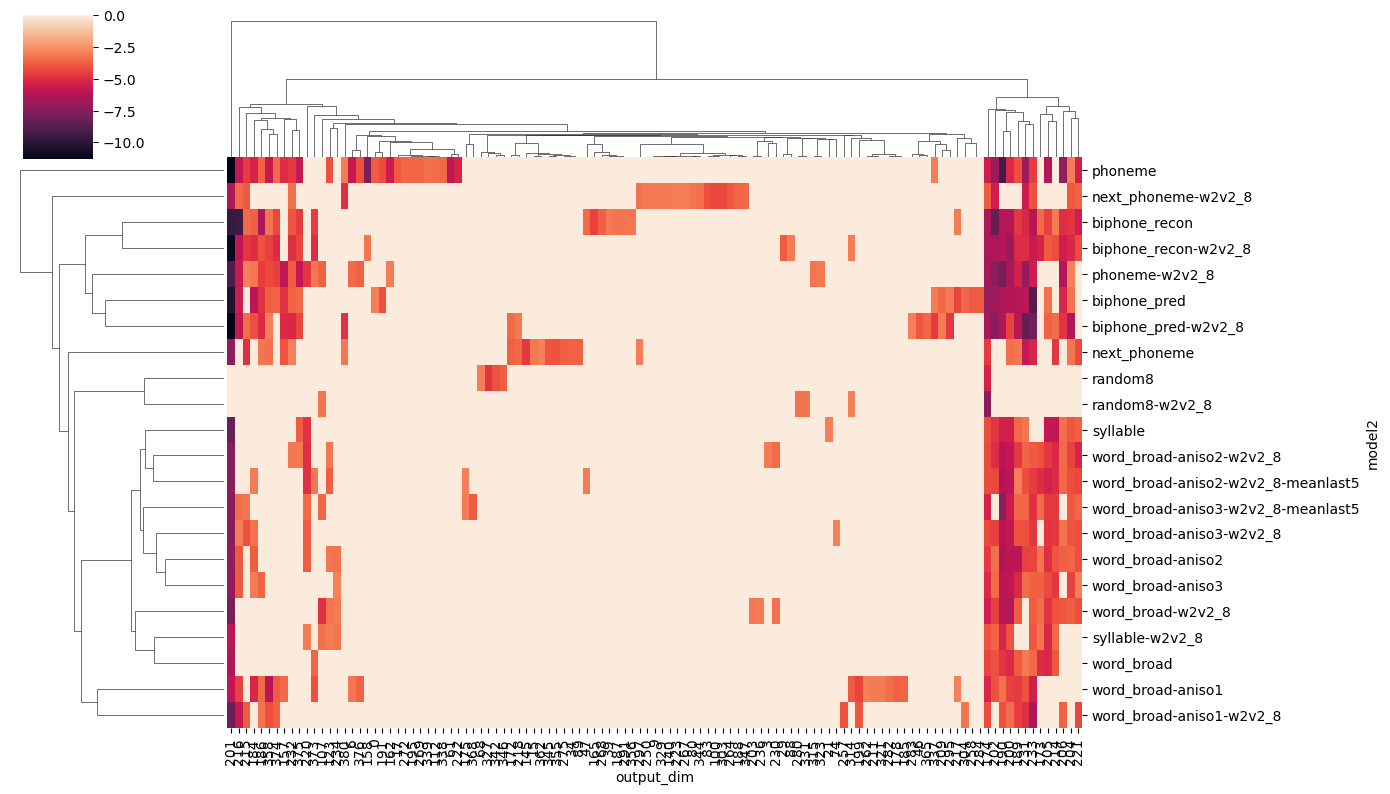

In [113]:
sns.clustermap(log_pvals, vmax=0, xticklabels=1, figsize=(14, 8))

## Colocation

### Colocation of baseline predictiveness and model improvement

In [114]:
score_relationship = scores_df.assign(model=scores_df.model.replace({model_name: "full_model" for model_name in set(scores_df.model) - {"baseline"}})) \
    .reset_index().pivot(index=["model2", "output_dim", "fold"], columns="model", values="score")
score_relationship

model                              baseline  full_model
model2            output_dim fold                      
biphone_pred      0          0     0.000318    0.000700
                             1    -0.000303   -0.000701
                             2     0.001780    0.002129
                  1          0     0.003573    0.001338
                             1     0.000343   -0.001289
...                                     ...         ...
word_broad-w2v2_8 382        1    -0.001886   -0.003440
                             2     0.000010   -0.000874
                  383        0    -0.002824   -0.003325
                             1    -0.001290   -0.002021
                             2    -0.001430   -0.002243

[25344 rows x 2 columns]

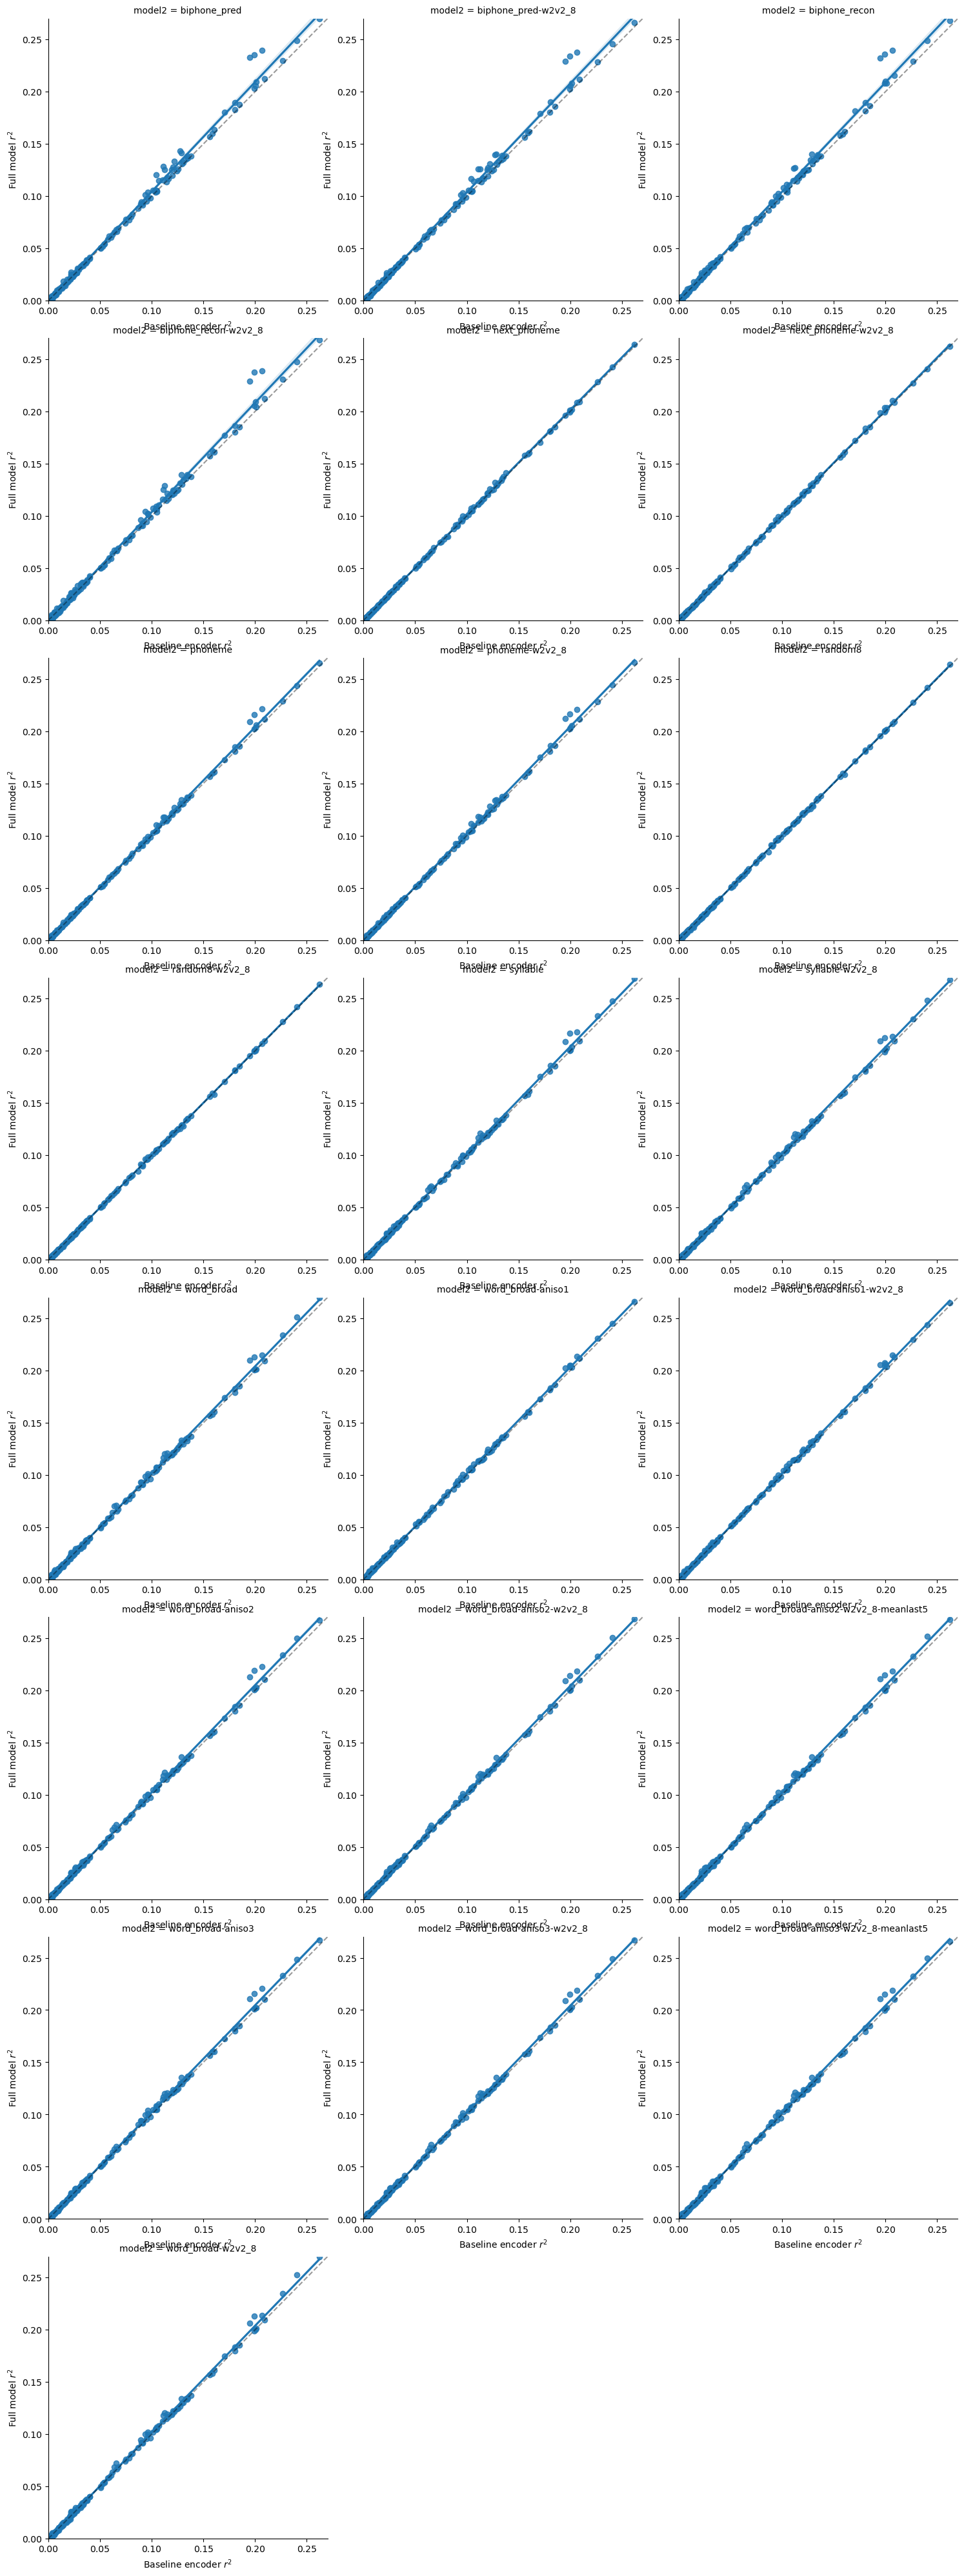

In [115]:
g = sns.lmplot(data=score_relationship.reset_index(), x="baseline", y="full_model", col="model2", col_wrap=3,
               facet_kws=dict(sharex=False, sharey=False))

ax_min = 0.
ax_max = score_relationship.max().max()
for ax in g.axes.ravel():
    ax.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.4)
    ax.set_xlim(ax_min, ax_max)
    ax.set_ylim(ax_min, ax_max)
    ax.set_xlabel("Baseline encoder $r^2$")
    ax.set_ylabel("Full model $r^2$")

### Colocation of model embedding and TRF weights

Which electrodes demonstrate simultaneous activation in response to acoustic-phonetic weights and also model embeddings?

In [116]:
study_model = "word_broad"
study_coef = coef_df.loc["baseline"].reset_index().set_index("output_dim")
study_coef["feature_is_phonetic"] = study_coef.feature.isin(phonetic_features)
study_coef["feature_is_prosodic"] = study_coef.feature.isin(("F0", "maxDtL"))
study_coef["base_feature"] = study_coef.feature.str.split("_", expand=True)[0]
study_coef["significantly_predicted"] = False
study_coef.loc[ttest_df.loc[study_model].droplevel("model1").index, "significantly_predicted"] = True

study_coef

model  fold feature output_name  input_dim  lag  time  \
output_dim                                                             
0           baseline     0   onset         SG1          0    0  0.00   
0           baseline     0   onset         SG1          0    1  0.01   
0           baseline     0   onset         SG1          0    2  0.02   
0           baseline     0   onset         SG1          0    3  0.03   
0           baseline     0   onset         SG1          0    4  0.04   
...              ...   ...     ...         ...        ...  ...   ...   
383         baseline     2      F0       PG128         12   56  0.56   
383         baseline     2      F0       PG128         12   57  0.57   
383         baseline     2      F0       PG128         12   58  0.58   
383         baseline     2      F0       PG128         12   59  0.59   
383         baseline     2      F0       PG128         12   60  0.60   

                coef  feature_is_phonetic  feature_is_prosodic base_feature  \
output_dim                                                                    
0          -0.000854                False                False        onset   
0          -0.000821                False                False        onset   
0          -0.000827                False                False        onset   
0          -0.000722                False                False        onset   
0          -0.000270                False                False        onset   
...              ...                  ...                  ...          ...   
383         0.000264                False                 True           F0   
383         0.000237                False                 True           F0   
383         0.000325                False                 True           F0   
383         0.000461                False                 True           F0   
383         0.000712                False                 True           F0   

            significantly_predicted  
output_dim                           
0                             False  
0                             False  
0                             False  
0                             False  
0                             False  
...                             ...  
383                           False  
383                           False  
383                           False  
383                           False  
383                           False  

[913536 rows x 12 columns]

In [117]:
electrode_pvals = ttest_df.loc[(slice(None), "baseline"), "log_pval"].groupby(["model2", "output_dim"]).max()
# insert zero tvalues for missing electrode--model combinations
electrode_pvals = electrode_pvals.reindex(pd.MultiIndex.from_product([ttest_df.index.get_level_values("model2").unique(), study_coef.index.unique()])).fillna(0.)

feature_norms = study_coef.groupby(["base_feature", "output_dim", "fold"]).coef.apply(np.linalg.norm) \
    .groupby(["base_feature", "output_dim"]).mean().to_frame("feature_norm")
norm_study_df = pd.merge(feature_norms, electrode_pvals, left_index=True, right_index=True,
                         how="inner", validate="one_to_many").sort_index()
norm_study_df

feature_norm  \
output_dim base_feature     model2                                             
0          F0               biphone_pred                            0.009475   
                            biphone_pred-w2v2_8                     0.009475   
                            biphone_recon                           0.009475   
                            biphone_recon-w2v2_8                    0.009475   
                            next_phoneme                            0.009475   
...                                                                      ...   
383        phnfeatConsOnset word_broad-aniso2-w2v2_8-meanlast5      0.012338   
                            word_broad-aniso3                       0.012338   
                            word_broad-aniso3-w2v2_8                0.012338   
                            word_broad-aniso3-w2v2_8-meanlast5      0.012338   
                            word_broad-w2v2_8                       0.012338   

                                                                log_pval  
output_dim base_feature     model2                                        
0          F0               biphone_pred                       -3.035286  
                            biphone_pred-w2v2_8                 0.000000  
                            biphone_recon                       0.000000  
                            biphone_recon-w2v2_8                0.000000  
                            next_phoneme                       -1.686100  
...                                                                  ...  
383        phnfeatConsOnset word_broad-aniso2-w2v2_8-meanlast5  0.000000  
                            word_broad-aniso3                   0.000000  
                            word_broad-aniso3-w2v2_8            0.000000  
                            word_broad-aniso3-w2v2_8-meanlast5  0.000000  
                            word_broad-w2v2_8                   0.000000  

[42240 rows x 2 columns]

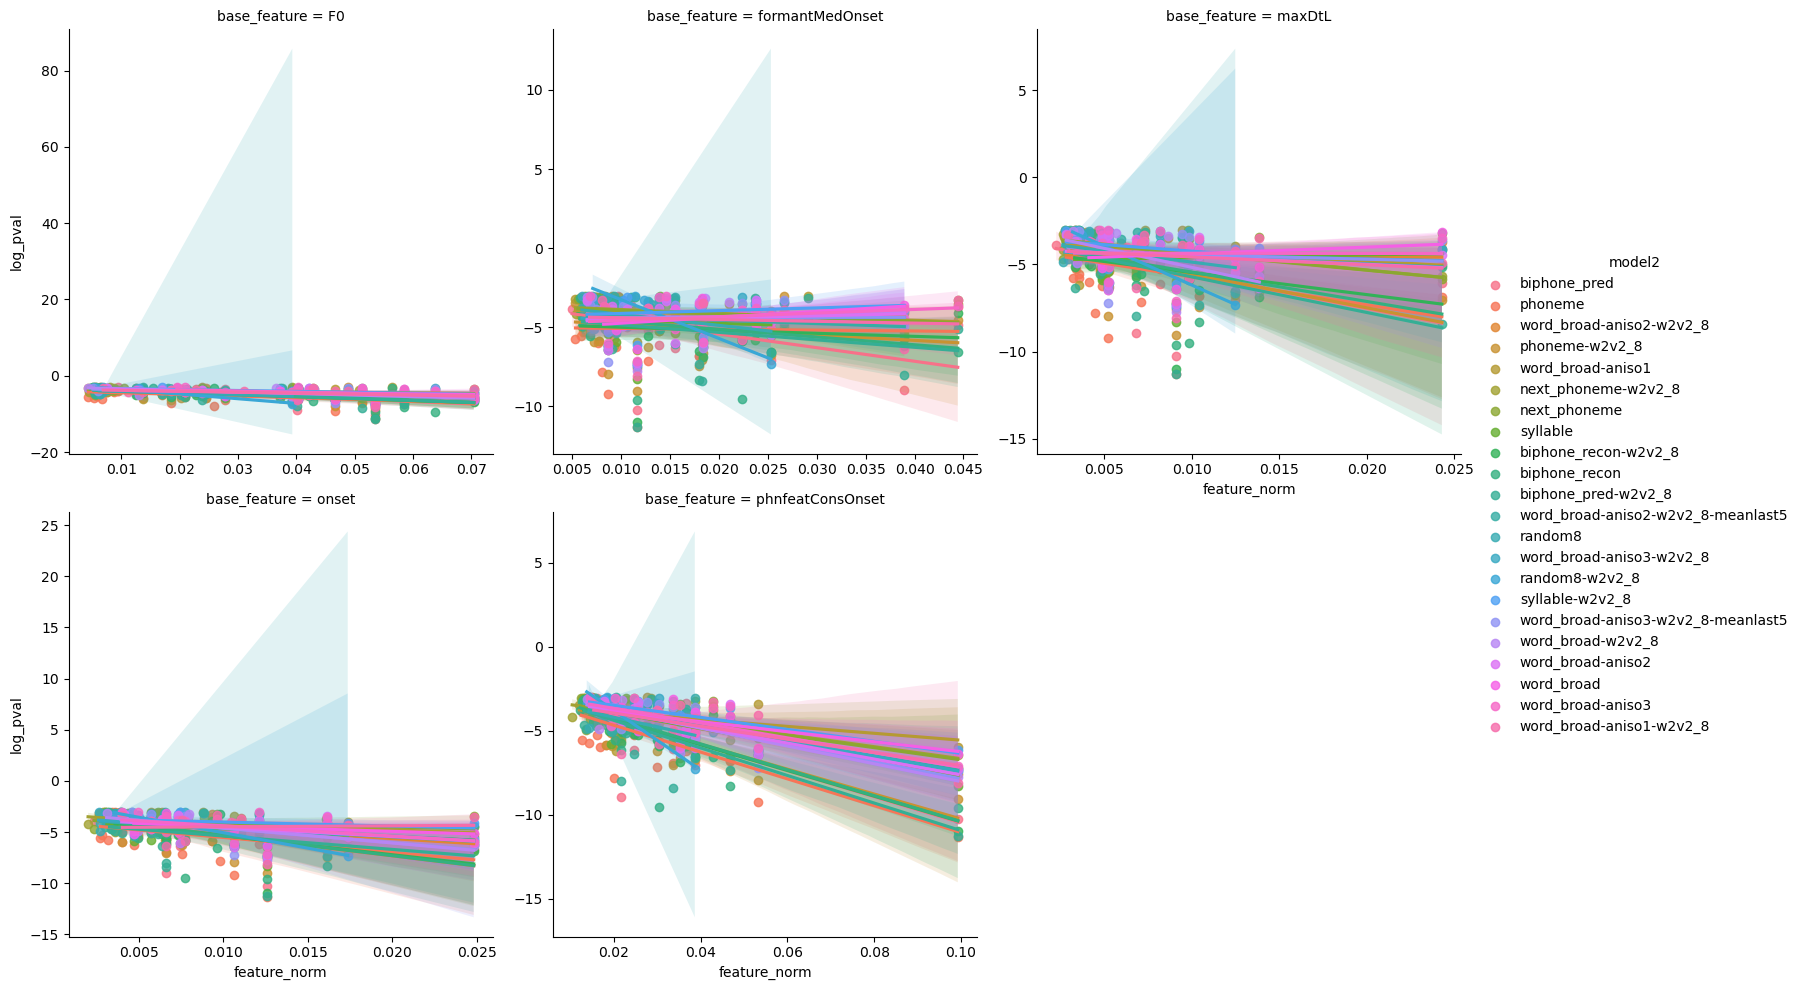

In [118]:
plot_norm_study_df = norm_study_df.reset_index()
plot_norm_study_df = plot_norm_study_df[plot_norm_study_df.log_pval < np.log10(pval_threshold)]
# drop outliers
# tval_max = np.percentile(norm_study_df.tval, 99)
# plot_norm_study_df = plot_norm_study_df[plot_norm_study_df.tval < tval_max]

g = sns.lmplot(data=plot_norm_study_df, x="feature_norm", y="log_pval", col="base_feature",
               hue="model2", facet_kws=dict(sharex=False, sharey=False), col_wrap=3)
# drop outliers
# g.set(ylim=(0, tval_max))

# TODO just look for qualitative examples
# find 2 peakRate-tuned electrodes, one improved by word and one improved by phoneme
# then look at sentence/word/syllable/peakRate-aligned ERPs on e.g. median split of peakRate
# point is to find qualitative link between feature contrast and model comparison

# TODO also look in weight space -- do we see difference in e.g. morphology of ac-phon response vs. morphology of embedding response?
# or look for electrodes which exhibit different magnitudes of evoked response to ac-phon vs embedding in different directions

# These might live in PC20, but show that they emerge from computations on PC1/PC2

In [119]:
plot_norm_study_df[(plot_norm_study_df.base_feature == "maxDtL") & (plot_norm_study_df.log_pval < -3) &
                   (plot_norm_study_df.feature_norm > 0.015)]

output_dim base_feature                              model2  \
25454         231       maxDtL                        biphone_pred   
25455         231       maxDtL                 biphone_pred-w2v2_8   
25456         231       maxDtL                       biphone_recon   
25457         231       maxDtL                biphone_recon-w2v2_8   
25458         231       maxDtL                        next_phoneme   
25459         231       maxDtL                 next_phoneme-w2v2_8   
25460         231       maxDtL                             phoneme   
25461         231       maxDtL                      phoneme-w2v2_8   
25464         231       maxDtL                            syllable   
25466         231       maxDtL                          word_broad   
25467         231       maxDtL                   word_broad-aniso1   
25468         231       maxDtL            word_broad-aniso1-w2v2_8   
25469         231       maxDtL                   word_broad-aniso2   
25470         231       maxDtL            word_broad-aniso2-w2v2_8   
25471         231       maxDtL  word_broad-aniso2-w2v2_8-meanlast5   
25472         231       maxDtL                   word_broad-aniso3   
25473         231       maxDtL            word_broad-aniso3-w2v2_8   
25474         231       maxDtL  word_broad-aniso3-w2v2_8-meanlast5   

       feature_norm  log_pval  
25454      0.024309 -6.064039  
25455      0.024309 -8.418744  
25456      0.024309 -5.153170  
25457      0.024309 -5.035831  
25458      0.024309 -5.856815  
25459      0.024309 -5.639372  
25460      0.024309 -6.896658  
25461      0.024309 -7.069383  
25464      0.024309 -3.225651  
25466      0.024309 -3.120217  
25467      0.024309 -4.102728  
25468      0.024309 -4.945513  
25469      0.024309 -4.463226  
25470      0.024309 -3.687710  
25471      0.024309 -4.160752  
25472      0.024309 -3.457350  
25473      0.024309 -4.138450  
25474      0.024309 -3.586871

In [120]:
norm_study_df.loc[([190], "phnfeatConsOnset"), :]

feature_norm  \
output_dim base_feature     model2                                             
190        phnfeatConsOnset biphone_pred                             0.05332   
                            biphone_pred-w2v2_8                      0.05332   
                            biphone_recon                            0.05332   
                            biphone_recon-w2v2_8                     0.05332   
                            next_phoneme                             0.05332   
                            next_phoneme-w2v2_8                      0.05332   
                            phoneme                                  0.05332   
                            phoneme-w2v2_8                           0.05332   
                            random8                                  0.05332   
                            random8-w2v2_8                           0.05332   
                            syllable                                 0.05332   
                            syllable-w2v2_8                          0.05332   
                            word_broad                               0.05332   
                            word_broad-aniso1                        0.05332   
                            word_broad-aniso1-w2v2_8                 0.05332   
                            word_broad-aniso2                        0.05332   
                            word_broad-aniso2-w2v2_8                 0.05332   
                            word_broad-aniso2-w2v2_8-meanlast5       0.05332   
                            word_broad-aniso3                        0.05332   
                            word_broad-aniso3-w2v2_8                 0.05332   
                            word_broad-aniso3-w2v2_8-meanlast5       0.05332   
                            word_broad-w2v2_8                        0.05332   

                                                                log_pval  
output_dim base_feature     model2                                        
190        phnfeatConsOnset biphone_pred                       -6.457661  
                            biphone_pred-w2v2_8                -6.426381  
                            biphone_recon                      -6.225801  
                            biphone_recon-w2v2_8               -6.122894  
                            next_phoneme                       -1.426064  
                            next_phoneme-w2v2_8                -2.551885  
                            phoneme                            -9.233461  
                            phoneme-w2v2_8                     -7.935286  
                            random8                            -1.200388  
                            random8-w2v2_8                     -0.734077  
                            syllable                           -5.430909  
                            syllable-w2v2_8                    -5.285109  
                            word_broad                         -4.797144  
                            word_broad-aniso1                  -3.393115  
                            word_broad-aniso1-w2v2_8           -4.083400  
                            word_broad-aniso2                  -6.443132  
                            word_broad-aniso2-w2v2_8           -6.192941  
                            word_broad-aniso2-w2v2_8-meanlast5 -6.366698  
                            word_broad-aniso3                  -6.019943  
                            word_broad-aniso3-w2v2_8           -6.117712  
                            word_broad-aniso3-w2v2_8-meanlast5 -7.220212  
                            word_broad-w2v2_8                  -6.177111

In [172]:
contrast_focus = "word_broad-aniso2-w2v2_8"
greatest_contrast_elecs = electrode_pvals.groupby("output_dim").apply(
    lambda xs: xs.loc[contrast_focus] - xs.loc[["phoneme", "biphone_pred", "biphone_recon"]].min()).sort_values(ascending=True)
greatest_contrast_elecs.head(20)

output_dim  output_dim
3           3            -3.122847
220         220          -3.030820
107         107          -2.884655
57          57           -2.877727
368         368          -1.977715
214         214          -1.950265
175         175          -1.869738
167         167          -1.711818
76          76           -1.679279
125         125          -1.647468
230         230          -1.579147
317         317          -1.567979
235         235          -1.550208
74          74           -1.514749
310         310          -1.492806
40          40           -1.468693
297         297          -1.456176
114         114          -1.418623
329         329          -1.349542
188         188          -1.294939
Name: log_pval, dtype: float64

In [168]:
electrode_pvals.loc[contrast_focus].loc[greatest_contrast_elecs.head(20).index.get_level_values(0)]

output_dim
214   -5.126153
220   -4.986011
123   -3.219880
230   -3.511572
3     -3.122847
57    -2.889922
107   -2.884655
314   -2.559642
221   -5.243625
199   -2.237554
203   -2.180328
173   -4.073236
331   -2.136670
236   -2.013410
368   -1.977715
234   -1.870813
175   -1.869738
167   -1.711818
76    -1.679279
125   -1.647468
Name: log_pval, dtype: float64

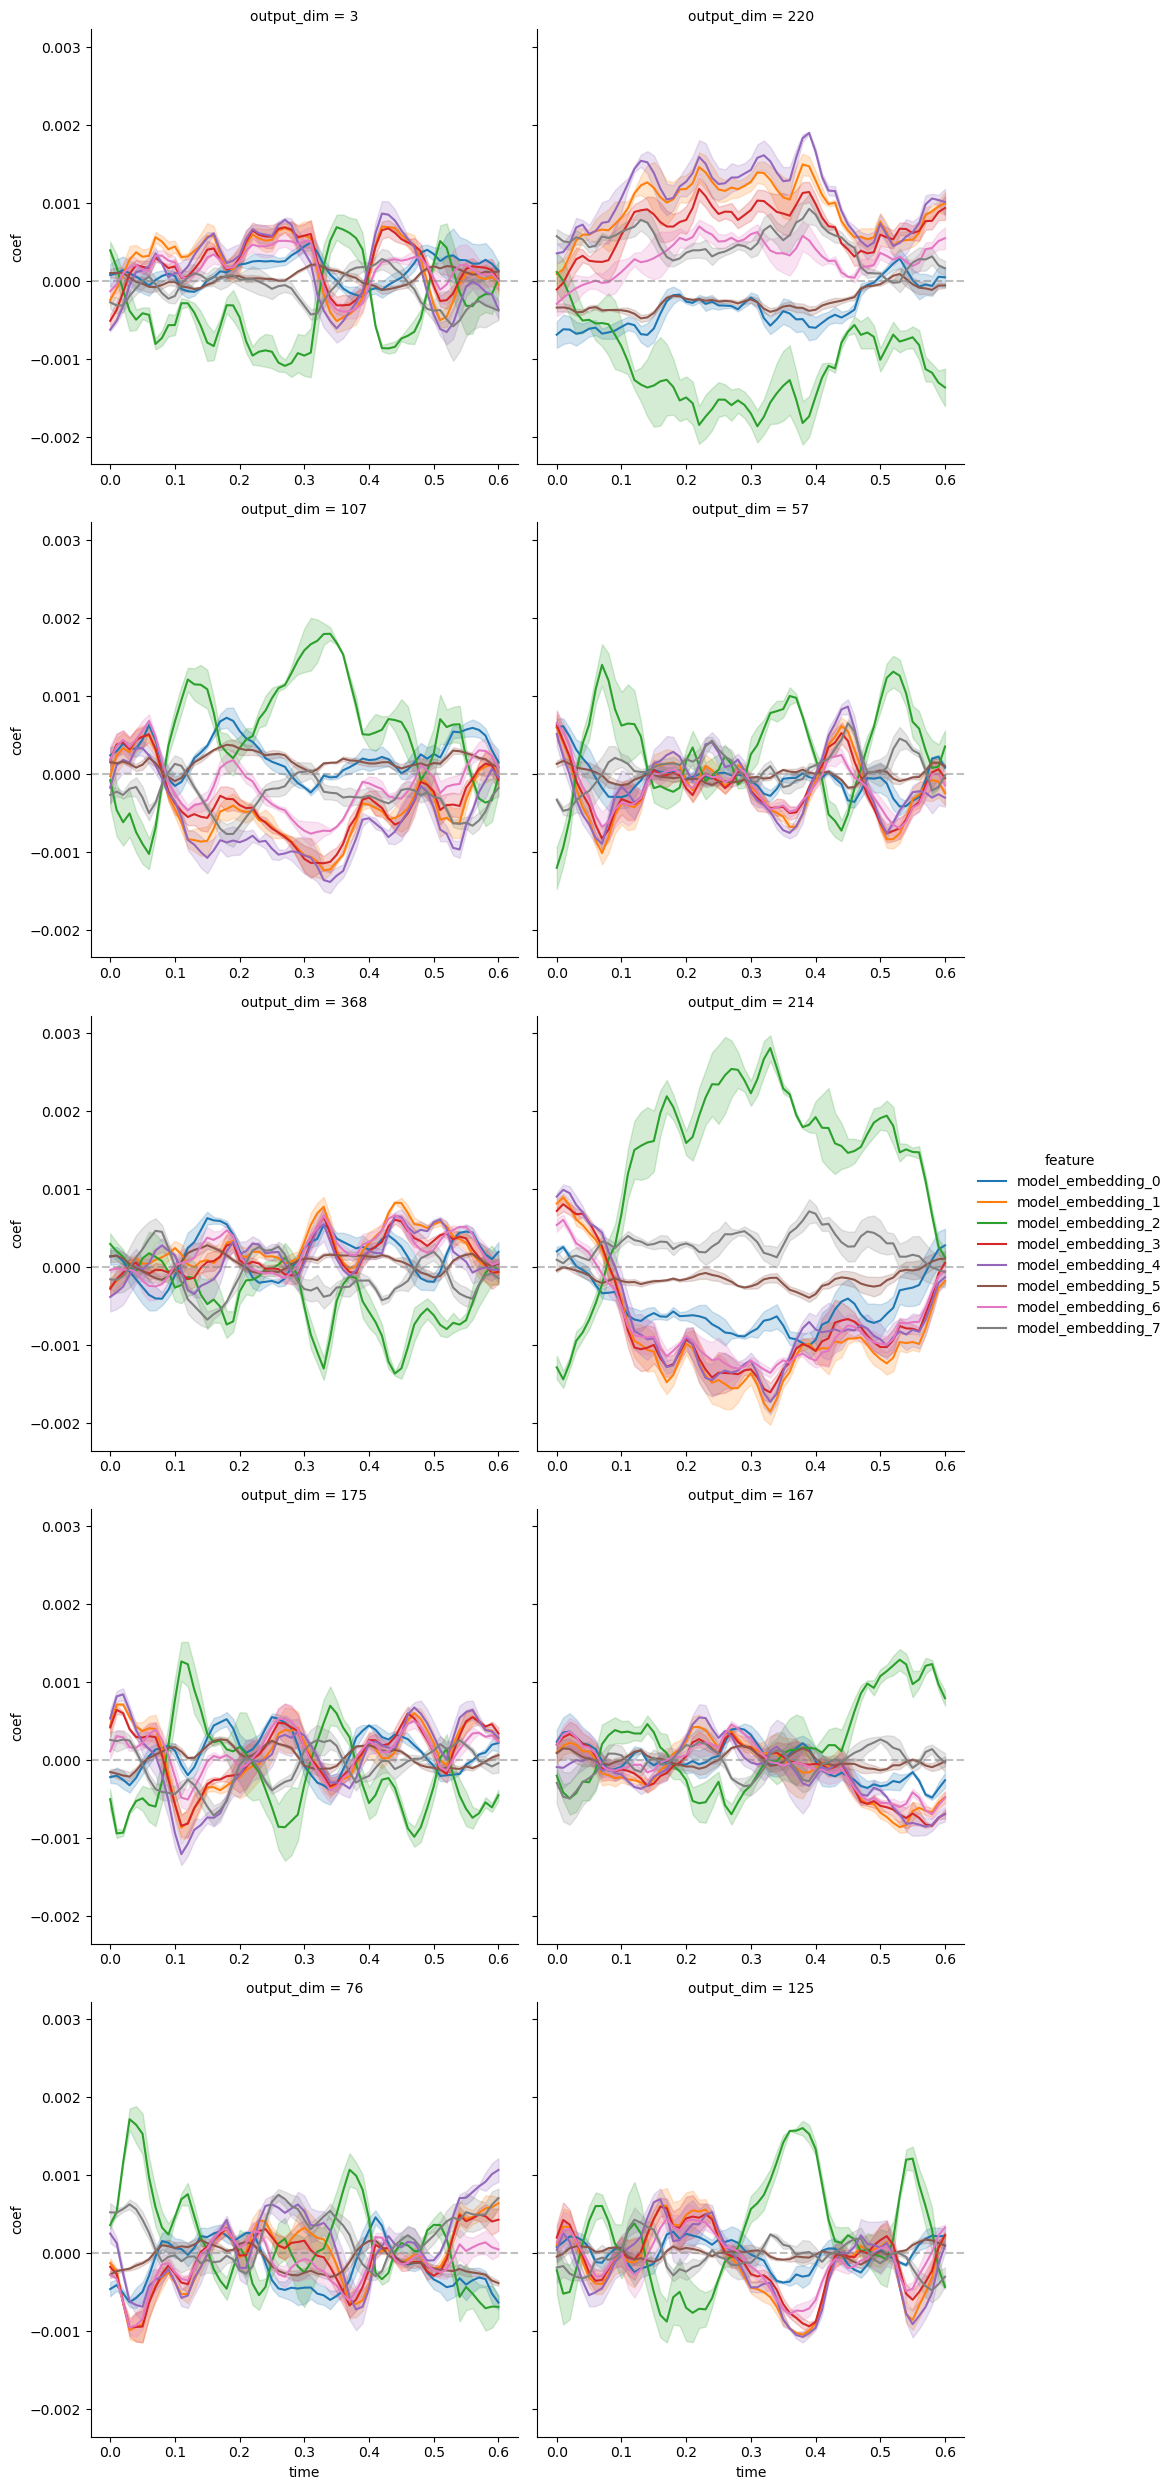

In [176]:
plot_greatest_contrast = greatest_contrast_elecs.head(10).index.get_level_values(0)
plot_greatest_contrast_df = coef_df.loc[contrast_focus]
plot_greatest_contrast_df = plot_greatest_contrast_df[plot_greatest_contrast_df.output_dim.isin(plot_greatest_contrast)]
plot_greatest_contrast_df = plot_greatest_contrast_df[plot_greatest_contrast_df.feature.str.startswith("model_embedding")]

g = sns.relplot(data=plot_greatest_contrast_df,
                col="output_dim", col_wrap=2, col_order=plot_greatest_contrast,
                x="time", y="coef", hue="feature", kind="line", errorbar="se",
                facet_kws=dict(sharex=False))
for ax in g.axes.ravel():
    ax.axhline(0, color="gray", linestyle="--", alpha=0.5)

In [178]:
contrast_focus = "word_broad-aniso2-w2v2_8"
def get_smallest_contrast(xs):
    focus_row = xs.loc[contrast_focus].item()
    if focus_row == 0:
        return np.inf
    baseline_value = xs.loc[["phoneme", "biphone_pred", "biphone_recon"]].min()
    if baseline_value == 0:
        return np.inf
    return np.abs(focus_row - baseline_value)
smallest_contrast_elecs = electrode_pvals.groupby("output_dim").apply(get_smallest_contrast).sort_values(ascending=True)
smallest_contrast_elecs = smallest_contrast_elecs[smallest_contrast_elecs < 1]
smallest_contrast_elecs.head(20)

output_dim
372    0.000289
132    0.097763
369    0.189096
172    0.231364
143    0.286053
221    0.294514
144    0.323168
204    0.392267
200    0.419934
173    0.521185
199    0.531389
257    0.581324
314    0.638484
234    0.716488
211    0.718350
225    0.750383
236    0.776870
331    0.855705
123    0.925637
Name: log_pval, dtype: float64

In [183]:
electrode_pvals.loc[(slice(None), smallest_contrast_elecs.index)].groupby("output_dim").min().sort_values(ascending=True)

output_dim
200   -6.852387
204   -6.362054
221   -5.538139
173   -5.266348
199   -4.389402
123   -4.145517
257   -4.118412
314   -3.894372
172   -3.770358
234   -3.315736
331   -3.285492
211   -3.112616
236   -3.104551
372   -2.942979
225   -2.634636
143   -2.441945
369   -2.163400
132   -2.134794
144   -1.264346
Name: log_pval, dtype: float64

In [123]:
study_f0_no_model = norm_study_df.loc[(slice(None), "F0"), :].groupby(["output_dim", "feature_norm"]).log_pval.min().reset_index()
study_f0_no_model = study_f0_no_model[study_f0_no_model.log_pval == 0]
study_f0_no_model.sort_values("feature_norm", ascending=False)

output_dim  feature_norm  log_pval
219         219      0.014885       0.0
1             1      0.010742       0.0
170         170      0.008926       0.0
247         247      0.008131       0.0
16           16      0.008077       0.0
..          ...           ...       ...
300         300      0.004449       0.0
149         149      0.004381       0.0
84           84      0.004230       0.0
131         131      0.003872       0.0
67           67      0.003804       0.0

[63 rows x 3 columns]

In [191]:
def render_electrode_panel(
        electrode, model_embeddings=None, features=None,
        trial_epoch_kwargs=None,
        word_epoch_kwargs=None,
        word_epoch2_kwargs=None,
        smoke_test=False):
    figure = plt.figure(figsize=(32, 24))
    gs = gridspec.GridSpec(3, 4, figure=figure,
                           width_ratios=[3, 3, 2, 2], hspace=0.25, wspace=0.25)
    electrodes = [electrode]

    errorbar = ("ci", 95) if not smoke_test else None

    if model_embeddings is None:
        model_embeddings = sorted([m for m in electrode_pvals.index.get_level_values("model2").unique() if m != "baseline"])
    if features is None:
        features = sorted([f for f in coef_df.feature.unique() if not f.startswith("model_embedding")])

    ##### plot electrode t-values and feature norms

    tval_ax = figure.add_subplot(gs[0, 0])
    tval_ax.set_title("Improvement log $p$-values by model embedding")
    tval_ax.axvline(np.log10(pval_threshold), color="black", linestyle="--", linewidth=2)
    feature_norm_ax = figure.add_subplot(gs[0, 1])
    feature_norm_ax.set_title("Feature norms")

    tval_df = electrode_pvals.loc[model_embeddings].loc[(slice(None), electrodes)]
    tval_df_order = tval_df.sort_values(ascending=True).index.get_level_values("model2")
    sns.barplot(data=tval_df.reset_index(), x="log_pval", y="model2",
                ax=tval_ax, order=tval_df_order)
    for ticklabel in tval_ax.get_yticklabels():
        if ticklabel.get_text() in model_embeddings:
            ticklabel.set_fontweight("bold")

    feature_norm_df = feature_norms.loc[(slice(None), electrodes), :]
    feature_norm_df_order = feature_norm_df.feature_norm.sort_values(ascending=False).index.get_level_values("base_feature")
    sns.barplot(data=feature_norm_df.reset_index(), x="feature_norm", y="base_feature",
                ax=feature_norm_ax, order=feature_norm_df_order)
    for ticklabel in feature_norm_ax.get_yticklabels():
        if ticklabel.get_text().startswith(tuple(features)):
            ticklabel.set_fontweight("bold")

    #####

    # prepare single coefficient df
    plot_coef_df = coef_df.loc[model_embeddings].reset_index()
    # name model embedding coefficients according to model
    model_coefs = plot_coef_df.loc[plot_coef_df.feature.str.startswith("model_embedding")]
    plot_coef_df.loc[plot_coef_df.feature.str.startswith("model_embedding"), "feature"] = \
        model_coefs.model.str.cat(model_coefs.feature, sep="_")

    # filter to electrodes of interest
    plot_coef_df = plot_coef_df[plot_coef_df.output_dim.isin(electrodes)]
    # filter to features of interest
    plot_coef_df_features = plot_coef_df[plot_coef_df.feature.str.startswith(tuple(features))]
    plot_coef_df_features = plot_coef_df_features[["fold", "feature", "output_dim", "time", "coef"]]
    plot_coef_df_features["type"] = "basic_feature"
    # add computed feature norms for embeddings
    plot_coef_df_embeddings = plot_coef_df[plot_coef_df.feature.str.contains("model_embedding")]
    plot_coef_df_embeddings = plot_coef_df_embeddings.groupby(["fold", "model", "output_dim", "time"]) \
        .coef.apply(lambda xs: xs.abs().sum()).reset_index() \
        .rename(columns={"model": "feature"}).assign(type="model_embedding")
    # add computed feature norms for embeddings
    plot_coef_subset_df = pd.concat([
        plot_coef_df_features,
        plot_coef_df_embeddings
    ])
    
    #####
    # coef_line_ax = figure.add_subplot(gs[1, :])
    # sns.lineplot(data=plot_coef_subset_df, x="time", y="coef", hue="feature", style="type", ax=coef_line_ax)

    #####

    feature_coef_heatmap_ax = figure.add_subplot(gs[1, :2])
    plot_coef_heatmap_df = plot_coef_df_features.pivot_table(
        index="feature", columns="time", values="coef", aggfunc="mean")
    plot_coef_heatmap_df = plot_coef_heatmap_df.loc[sorted(plot_coef_df_features.feature.unique())]
    sns.heatmap(plot_coef_heatmap_df, ax=feature_coef_heatmap_ax, cmap="RdBu", center=0, yticklabels=True)

    model_coef_heatmap_ax = figure.add_subplot(gs[2, :2])
    plot_coef_heatmap_df = plot_coef_df_embeddings.pivot_table(
        index="feature", columns="time", values="coef", aggfunc="mean")
    # # order by decreasing t-value
    # plot_coef_heatmap_df = plot_coef_heatmap_df.loc[[model for model in tval_df_order if model in plot_coef_heatmap_df.index]]
    # order by name
    plot_coef_heatmap_df = plot_coef_heatmap_df.loc[sorted(plot_coef_df_embeddings.feature.unique())]
    sns.heatmap(plot_coef_heatmap_df, ax=model_coef_heatmap_ax, cmap="RdBu", center=0, yticklabels=True)

    #####

    trial_epochs_ax = figure.add_subplot(gs[0, 2])
    trial_epochs_ax.set_title("Trial ERP")
    trial_epochs_ax.axvline(0, color="gray", linestyle="--")
    plot_trial_epochs = trial_epochs[(trial_epochs.electrode_idx == electrode)]
    sns.lineplot(data=plot_trial_epochs, x="epoch_time", y="value", ax=trial_epochs_ax,
                 errorbar=errorbar,
                 **(trial_epoch_kwargs or {}))

    word_epochs_ax = figure.add_subplot(gs[1, 2])
    word_epochs_ax.set_title("Word ERP")
    word_epochs_ax.axvline(0, color="gray", linestyle="--")
    plot_word_epochs = word_epochs[word_epochs.electrode_idx == electrode]
    sns.lineplot(data=plot_word_epochs, x="epoch_time", y="value", ax=word_epochs_ax,
                 errorbar=errorbar,
                 **(word_epoch_kwargs or {}))
    
    word_epochs2_ax = figure.add_subplot(gs[2, 2])
    word_epochs2_ax.set_title("Word ERP")
    word_epochs2_ax.axvline(0, color="gray", linestyle="--")
    plot_word_epochs2 = word_epochs[word_epochs.electrode_idx == electrode]
    sns.lineplot(data=plot_word_epochs2, x="epoch_time", y="value", ax=word_epochs2_ax,
                 errorbar=errorbar,
                 **(word_epoch2_kwargs or {}))

    syllable_epochs_ax = figure.add_subplot(gs[0, 3])
    syllable_epochs_ax.set_title("Syllable ERP")
    syllable_epochs_ax.axvline(0, color="gray", linestyle="--")
    plot_syllable_epochs = syllable_epochs[syllable_epochs.electrode_idx == electrode]
    sns.lineplot(data=plot_syllable_epochs, x="epoch_time", y="value", ax=syllable_epochs_ax,
                 errorbar=errorbar)

    plt.suptitle(f"Electrode {electrode} study")
    plt.tight_layout()
    
    return plot_coef_df

In [192]:
# electrodes showing greater response to word_broad than to biphone and phoneme features
panel_electrodes = plot_greatest_contrast.tolist()

# electrodes showing balanced response between word_broad and biphone/phoneme features
panel_electrodes += [200, 204, 221, 173, 199, 123, 257, 314, 172, 234, 331, 211]

# electrodes tuned to matched features and different models
# panel_electrodes = [231, 205, 373, 173, 214, 123]
# electrodes tuned to F0 but not to models
# panel_electrodes += [212, 33, 219, 193]

In [193]:
for electrode in tqdm(panel_electrodes):
    with plt.rc_context(rc={"font.size": 18}):
        render_electrode_panel(
            electrode,
            model_embeddings=[
                "random8",
                "phoneme",
                "biphone_recon",
                "biphone_pred",
                "next_phoneme",
                "syllable-w2v2_8",
                "word_broad-aniso2-w2v2_8",
            ],
            word_epoch_kwargs=dict(hue="monosyllabic"),
            word_epoch2_kwargs=dict(hue="word_frequency_quantile"))
        f = plt.gcf()
        f.savefig(f"electrode_panel-{subject}_{electrode}.png")
        f.clf()

  0%|          | 0/22 [00:00<?, ?it/s]

/tmp/ipykernel_3476946/1918833884.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1918833884.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1918833884.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1918833884.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1918833884.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1918833884.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layo

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

<Figure size 3200x2400 with 0 Axes>

Text(33.722222222222214, 0.5, 'Baseline $r^2$')

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


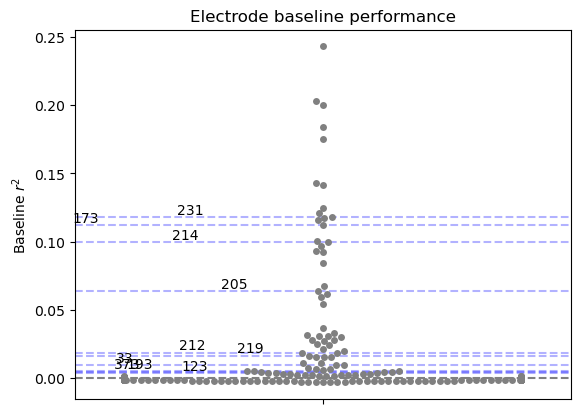

In [127]:
baseline_mean_scores = baseline_scores.groupby("output_dim").score.mean()
ax = sns.swarmplot(baseline_mean_scores, color="gray")
ax.axhline(0, color="gray", linestyle="--")

for elec, score in baseline_mean_scores.loc[panel_electrodes].items():
    ax.text(0.2 + np.random.normal(0, 0.1), score, elec, ha="center", va="bottom",
            transform=transforms.blended_transform_factory(ax.transAxes, ax.transData))
    ax.axhline(score, color="blue", linestyle="--", alpha=0.3)

ax.set_title("Electrode baseline performance")
ax.set_ylabel("Baseline $r^2$")

In [128]:
with plt.rc_context(rc={"font.size": 18}):
    g = sns.clustermap(ttest_df.loc[:, :, panel_electrodes].dropna().groupby(["model2", "model1", "output_dim"]).log_pval.max().reset_index() \
                    .pivot(index="output_dim", columns="model2", values="log_pval").fillna(0),
                cmap="viridis", figsize=(14, 8))
    g.ax_heatmap.set_title("Electrode model comparison $p$-values")

KeyError: 219

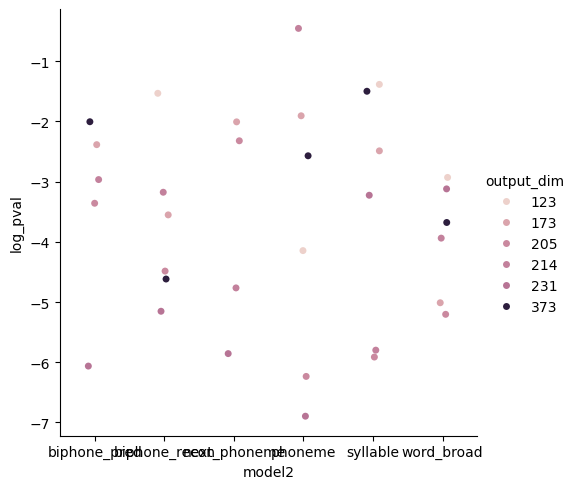

In [ ]:
sns.catplot(data=ttest_df.loc[:, :, panel_electrodes].dropna().groupby(["model2", "model1", "output_dim"]).log_pval.max().reset_index(),
            x="output_dim", y="log_pval", hue="output_dim")

In [ ]:
baseline_mean_scores.loc[panel_electrodes]

output_dim
231    0.117821
205    0.063889
373    0.004987
173    0.111884
214    0.099354
123    0.003638
Name: score, dtype: float64

In [ ]:
snapshot.all_state_spaces["word"].cuts.loc["bricks"]

description  onset_frame_idx  offset_frame_idx  \
instance_idx level                                                           
0            phoneme                  B           803502            803504   
             phoneme                  R           803504            803506   
             phoneme                 IH           803506            803510   
             phoneme                  K           803510            803514   
             phoneme                  S           803514            803518   
             syllable  (B, R, IH, K, S)           803502            803518   

                       item_idx  
instance_idx level               
0            phoneme       5252  
             phoneme       5252  
             phoneme       5252  
             phoneme       5252  
             phoneme       5252  
             syllable      5252

In [ ]:
word_epochs

epoch_idx  electrode_idx epoch_sample     value epoch_time  \
0                 0              0            0  0.708037       -0.1   
1                 0              1            0 -0.636341       -0.1   
2                 0              2            0 -0.015292       -0.1   
3                 0              3            0 -0.106601       -0.1   
4                 0              4            0 -0.503995       -0.1   
...             ...            ...          ...       ...        ...   
54959995       2999            453           39 -0.067755       0.29   
54959996       2999            454           39  1.562028       0.29   
54959997       2999            455           39  0.992946       0.29   
54959998       2999            456           39  0.844829       0.29   
54959999       2999            457           39  0.399839       0.29   

         epoch_label  epoch_duration_samples          name  item_idx  \
0             bricks                      40  fadg0_si1279      5252   
1             bricks                      40  fadg0_si1279      5252   
2             bricks                      40  fadg0_si1279      5252   
3             bricks                      40  fadg0_si1279      5252   
4             bricks                      40  fadg0_si1279      5252   
...              ...                     ...           ...       ...   
54959995  feverishly                      40  mzmb0_si1796      1133   
54959996  feverishly                      40  mzmb0_si1796      1133   
54959997  feverishly                      40  mzmb0_si1796      1133   
54959998  feverishly                      40  mzmb0_si1796      1133   
54959999  feverishly                      40  mzmb0_si1796      1133   

          trial_idx state_space  label_idx  instance_idx  \
0                 0        word       5497             0   
1                 0        word       5497             0   
2                 0        word       5497             0   
3                 0        word       5497             0   
4                 0        word       5497             0   
...             ...         ...        ...           ...   
54959995        498        word       2392             0   
54959996        498        word       2392             0   
54959997        498        word       2392             0   
54959998        498        word       2392             0   
54959999        498        word       2392             0   

                                       span_secs span_model_frames  \
0                (0.121175, 0.44430833333333336)           (6, 22)   
1                (0.121175, 0.44430833333333336)           (6, 22)   
2                (0.121175, 0.44430833333333336)           (6, 22)   
3                (0.121175, 0.44430833333333336)           (6, 22)   
4                (0.121175, 0.44430833333333336)           (6, 22)   
...                                          ...               ...   
54959995  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959996  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959997  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959998  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959999  (1.047457894736842, 1.732334210526316)          (52, 86)   

         span_ecog_samples span_ecog_samples_nopad  item_start_frame  \
0                 (62, 94)                (12, 44)            803496   
1                 (62, 94)                (12, 44)            803496   
2                 (62, 94)                (12, 44)            803496   
3                 (62, 94)                (12, 44)            803496   
4                 (62, 94)                (12, 44)            803496   
...                    ...                     ...               ...   
54959995        (154, 223)              (104, 173)            170494   
54959996        (154, 223)              (104, 173)            170494   
54959997        (154, 223)              (104, 173)            170494  

In [ ]:
ttest_filtered_df.loc[(slice(None), panel_electrodes), :].reset_index().set_index(["output_dim", "model2"]).sort_index()

Unnamed: 4 permutation       tval          pval  \
output_dim model2                                                           
123        phoneme                24       shift  16.920203  7.152914e-05   
173        biphone_recon          21       shift  11.955090  2.805105e-04   
           word_broad             11       units  27.963597  9.729389e-06   
205        biphone_pred           24       shift  10.666052  4.376286e-04   
           biphone_recon          15       shift  20.619528  3.267812e-05   
           phoneme                 6       shift  56.654666  5.811751e-07   
           syllable                7       shift  47.067152  1.218916e-06   
           word_broad              8       shift  31.249196  6.249377e-06   
214        biphone_recon          28       shift   9.566699  6.669787e-04   
           next_phoneme            4       shift  24.244899  1.716960e-05   
           syllable                9       units  44.055965  1.587238e-06   
           word_broad             24       shift  14.994255  1.152610e-04   
231        biphone_pred            8       shift  51.318364  8.629020e-07   
           biphone_recon           9       shift  30.342114  7.027965e-06   
           next_phoneme            1       shift  45.539989  1.390544e-06   
           phoneme                 4       shift  82.908127  1.268650e-07   
           syllable               40       units   9.854633  5.947699e-04   
           word_broad             34       units   9.253866  7.581981e-04   
373        biphone_recon          14       shift  22.258354  2.411891e-05   
           word_broad             27       units  12.877002  2.097153e-04   

                          log_pval  
output_dim model2                   
123        phoneme       -4.145517  
173        biphone_recon -3.552051  
           word_broad    -5.011914  
205        biphone_pred  -3.358894  
           biphone_recon -4.485743  
           phoneme       -6.235693  
           syllable      -5.914026  
           word_broad    -5.204163  
214        biphone_recon -3.175888  
           next_phoneme  -4.765240  
           syllable      -5.799358  
           word_broad    -3.938318  
231        biphone_pred  -6.064039  
           biphone_recon -5.153170  
           next_phoneme  -5.856815  
           phoneme       -6.896658  
           syllable      -3.225651  
           word_broad    -3.120217  
373        biphone_recon -4.617642  
           word_broad    -3.678370

In [ ]:
feature_norms_phonetic = study_coef.groupby(["feature", "output_dim", "feature_is_phonetic", "significantly_predicted"]).coef.apply(np.linalg.norm).to_frame("coef").reset_index()
# sns.barplot(x="feature_is_phonetic", y="coef", hue="significantly_predicted", data=feature_norms_phonetic)

<Axes: xlabel='time', ylabel='coef'>

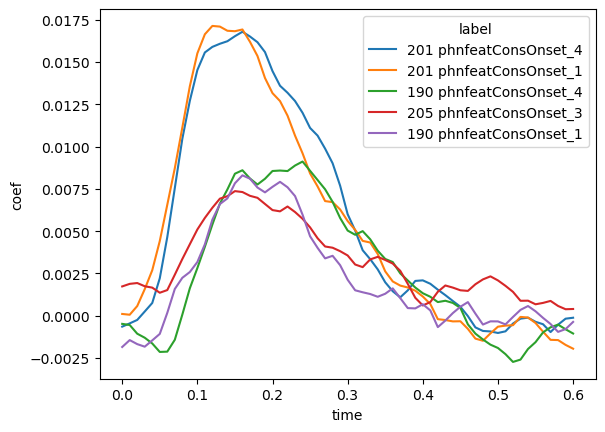

In [ ]:
# Find largest-norm phonetic responses
plot_n = 5
max_norm_phonetic_responses = feature_norms_phonetic[feature_norms_phonetic.feature_is_phonetic == True].sort_values("coef", ascending=False).set_index(["output_dim", "feature"]).head(plot_n).index
plot_df = study_coef.set_index("feature", append=True).loc[max_norm_phonetic_responses].reset_index()
plot_df["label"] = plot_df.output_dim.astype(str) + " " + plot_df.feature
sns.lineplot(data=plot_df, x="time", y="coef", hue="label")

### Colocation of model embedding and onset electrodes

In [ ]:
onset_coef_norm = study_coef[study_coef.feature == "onset"].groupby("output_dim") \
    .coef.apply(np.linalg.norm).sort_values(ascending=False)


/tmp/ipykernel_1754560/2648713857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)


<Axes: xlabel='epoch_time', ylabel='value'>

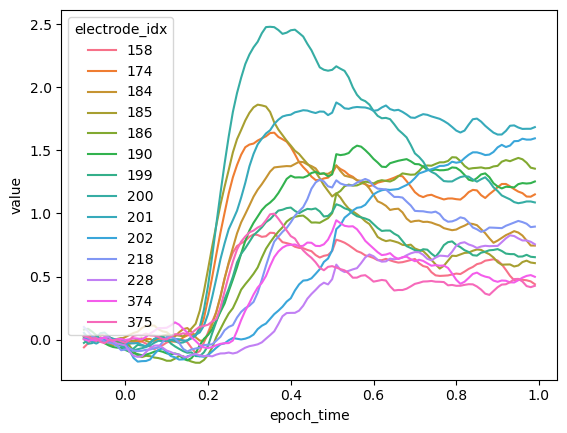

In [ ]:
norm_threshold = 0.009
plot_epochs = trial_epochs[trial_epochs.electrode_idx.isin(onset_coef_norm[onset_coef_norm > norm_threshold].index)]
plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)
sns.lineplot(data=plot_epochs,
             x="epoch_time", y="value", hue="electrode_idx", errorbar=None)

In [ ]:
# TODO ask across subject: does model embedding norm predict onset-like response or not?

In [ ]:
embedding_coef_norms = coef_df[coef_df.feature.str.startswith("model_embedding")] \
    .groupby(["model", "output_dim", "feature"]).coef.apply(np.linalg.norm) \
    .groupby(["model", "output_dim"]).mean()
onset_embedding_coef_norms = pd.merge(
    onset_coef_norm, embedding_coef_norms, left_index=True, right_index=True,
    suffixes=("_onset", "_embedding"))
onset_embedding_coef_norms

coef_onset  coef_embedding
model        output_dim                            
biphone_pred 0             0.004365        0.004765
             1             0.003818        0.004052
             2             0.002792        0.003892
             3             0.003488        0.003821
             4             0.003857        0.003661
...                             ...             ...
word_broad   379           0.002618        0.002522
             380           0.003286        0.002754
             381           0.003445        0.003202
             382           0.003590        0.002902
             383           0.002325        0.002572

[2688 rows x 2 columns]

<Axes: xlabel='coef_onset', ylabel='coef_embedding'>

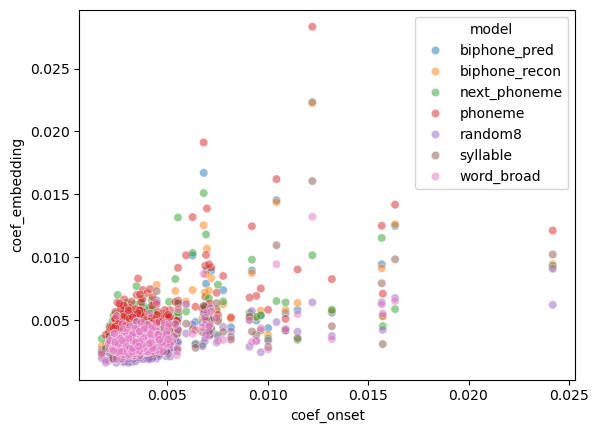

In [ ]:
sns.scatterplot(data=onset_embedding_coef_norms.reset_index(),
                x="coef_onset", y="coef_embedding", hue="model",
                alpha=0.5)

In [ ]:
onset_emb_correlations = onset_embedding_coef_norms \
    .groupby("model").apply(lambda df: pd.Series(spearmanr(df.coef_onset, df.coef_embedding), index=["rho", "pval"])) \
    .sort_values("rho")
onset_emb_correlations

rho          pval
model                                
next_phoneme   0.279621  2.502162e-08
word_broad     0.353505  9.580770e-13
syllable       0.394916  8.783515e-16
biphone_recon  0.413294  2.829718e-17
phoneme        0.430619  9.094437e-19
random8        0.435538  3.303479e-19
biphone_pred   0.468962  2.155644e-22

## ERPs for top-explained electrodes

In [ ]:
def plot_epochs(epochs_df, facet_kwargs=None, col_order="peak_value"):
    if col_order == "peak_value":
        # Order columns by peak mean value
        col_order = epochs_df.groupby(["electrode_idx", "epoch_sample"]) \
            .value.mean().abs().groupby("electrode_idx").max() \
            .sort_values(ascending=False).index
    elif isinstance(col_order, (list, tuple)):
        assert set(col_order) <= set(epochs_df.electrode_idx.unique())
        col_order = col_order
    else:
        raise ValueError(f"Unrecognized col_order: {col_order}")

    g = sns.relplot(data=epochs_df,
                    x="epoch_time", y="value", col="electrode_idx",
                    col_wrap=3, col_order=col_order, kind="line",
                    facet_kws={"sharex": False}, **(facet_kwargs or {}))

    # standard y-position for each model
    model_rect_size = 0.05
    get_model_position = lambda model_name: 0.1 + model_rect_size * sorted(encoder_names).index(model_name)

    for ax, electrode_idx in zip(g.axes.ravel(), col_order):
        ax.axvline(0, color="gray", linestyle="--")
        ax.axhline(0, color="gray", linestyle="--")

        # which models show significant prediction of this electrode?
        for model_name, log_pval_i in log_pvals[electrode_idx].items():
            alpha = 0.05 if log_pval_i == 0 else 0.8
            rect = plt.Rectangle((0.05, get_model_position(model_name)), model_rect_size, model_rect_size,
                                  color=get_model_color(model_name), alpha=alpha, transform=ax.transAxes)
            
            if log_pval_i != 0:
                # annotate with score
                ax.text(0.12, get_model_position(model_name), f"{np.power(10, log_pval_i):.1g}",
                        verticalalignment="bottom", alpha=0.8,
                        transform=ax.transAxes)
            ax.add_patch(rect)
            
    # add a model legend above the top of the facet grid
    legend_ax = g.fig.add_axes([0.1, 1.0, 0.8, 0.05])
    legend_ax.axis("off")
    for model_name in encoder_names:
        legend_ax.add_patch(plt.Rectangle((0.75 * model_rect_size, get_model_position(model_name)), model_rect_size, model_rect_size,
                                        color=get_model_color(model_name), alpha=0.8, transform=legend_ax.transAxes))
        legend_ax.text(0.1, get_model_position(model_name), model_name, verticalalignment="bottom",
                    transform=legend_ax.transAxes)
        
    return g

### Trial onset ERP for top-explained electrodes

In [ ]:
plot_epoch_electrodes = ttest_filtered_df.loc["word_broad"].sort_values("pval") \
    .index.get_level_values("output_dim").unique().to_list()
plot_trial_epochs = trial_epochs[trial_epochs.electrode_idx.isin(plot_epoch_electrodes)]

  0%|          | 0/12 [00:00<?, ?it/s]

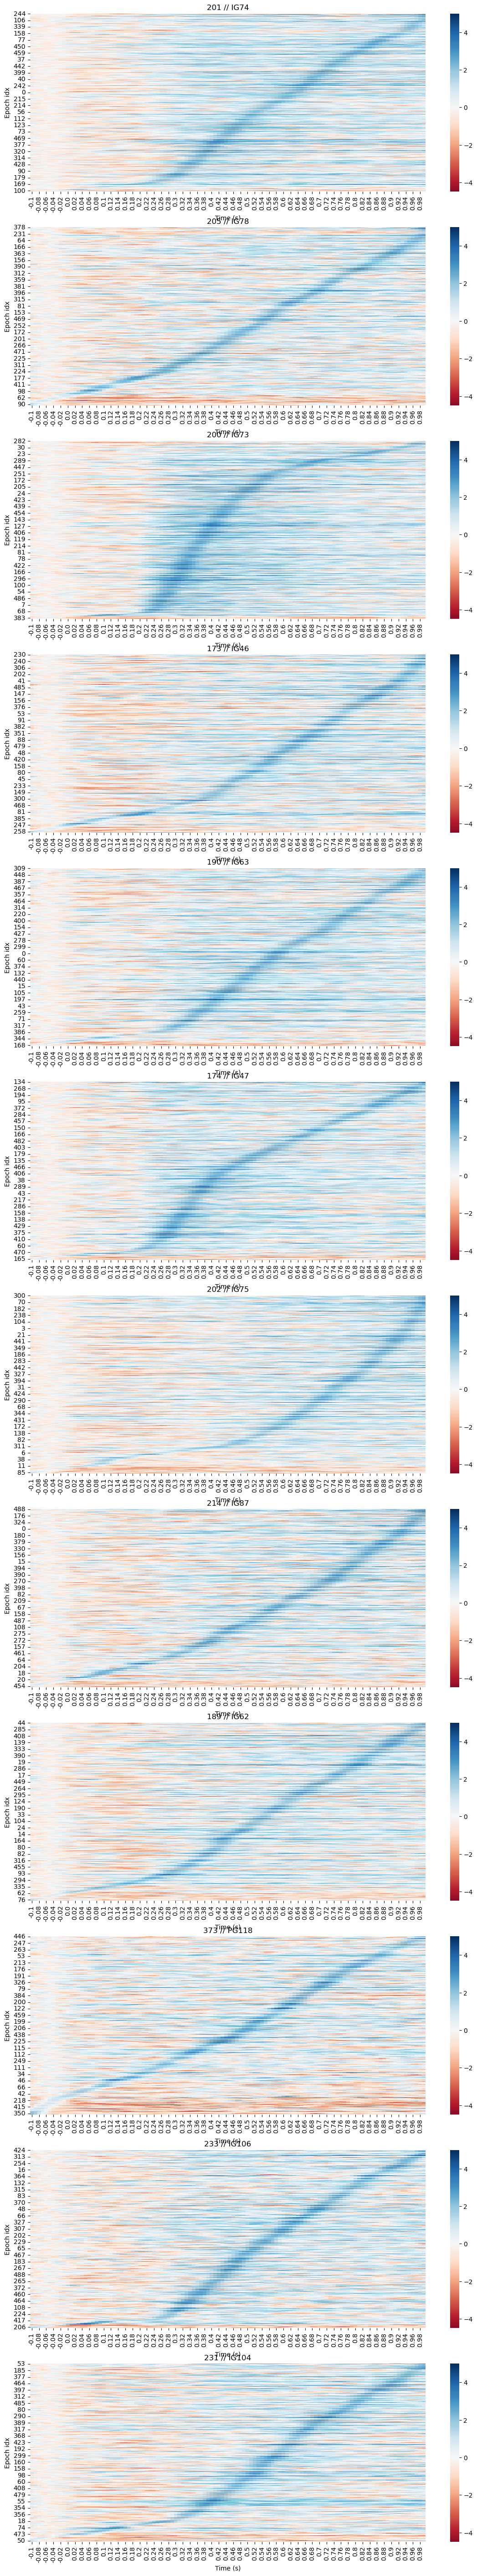

In [ ]:
plot_epoch_raster(plot_trial_epochs, electrode_df,
                  order=plot_epoch_electrodes)
# TODO sort each trial by single-trial predictivity under model
    # what proportion of trials are actually well explained by model embedding?
    # do raw HGA responses look similar for these trials? & compare to other trials
        # e.g. similarly timed peaks

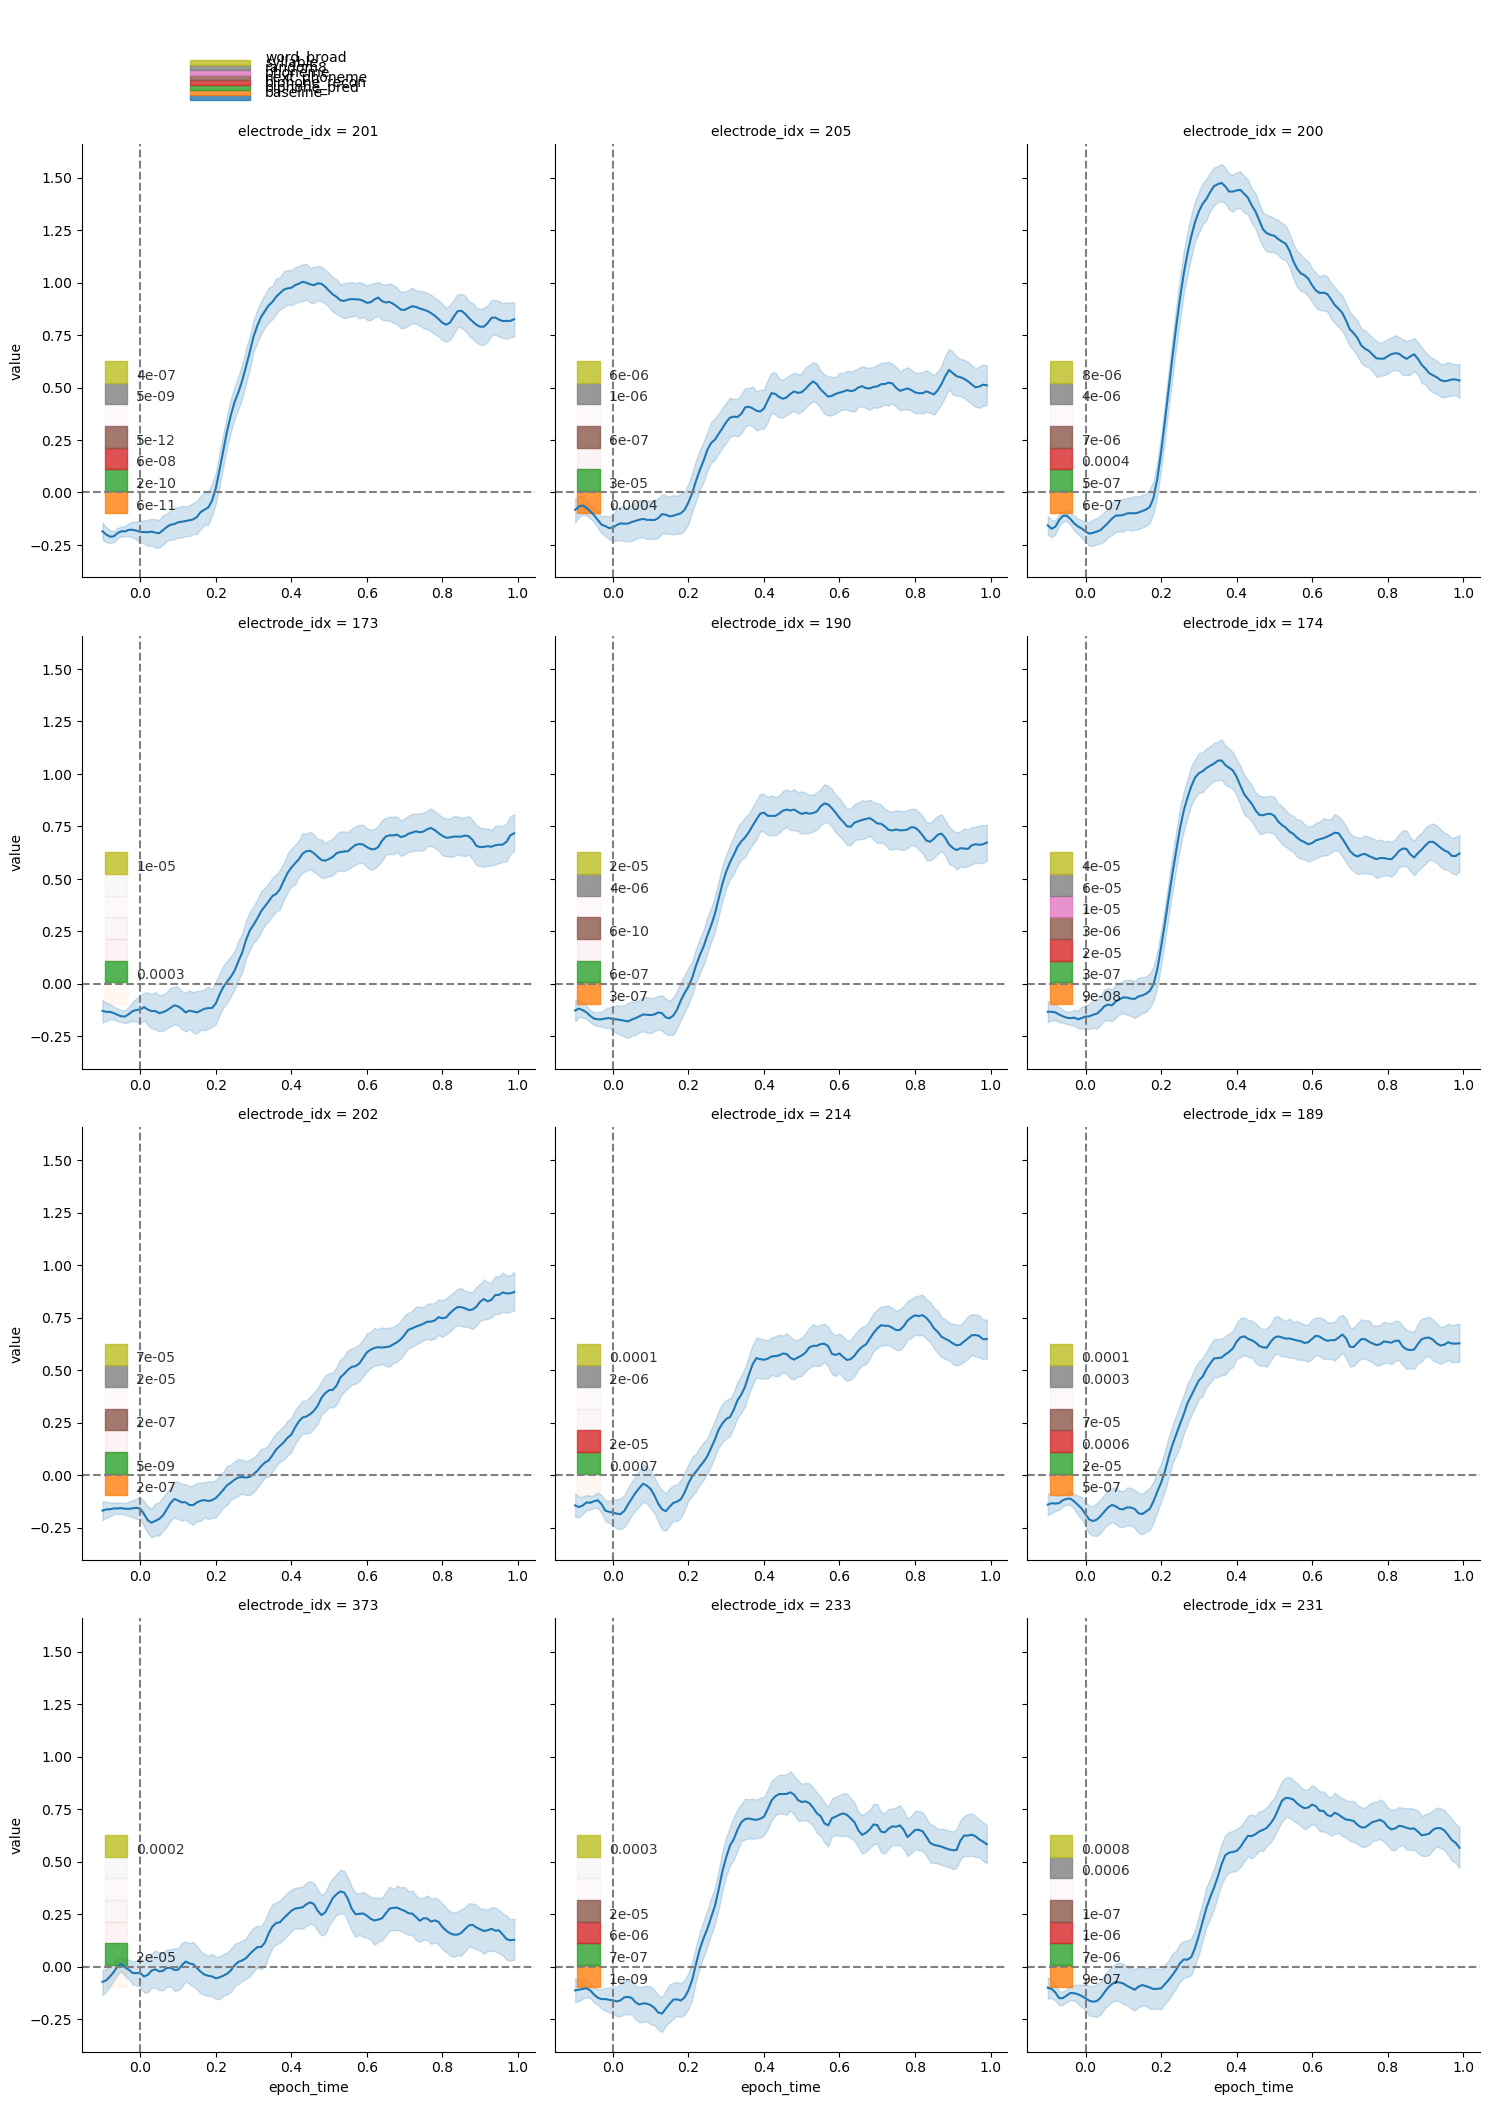

In [ ]:
plot_epochs(plot_trial_epochs, col_order=plot_epoch_electrodes)

### Word onset ERP for top-explained electrodes

  0%|          | 0/3052 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

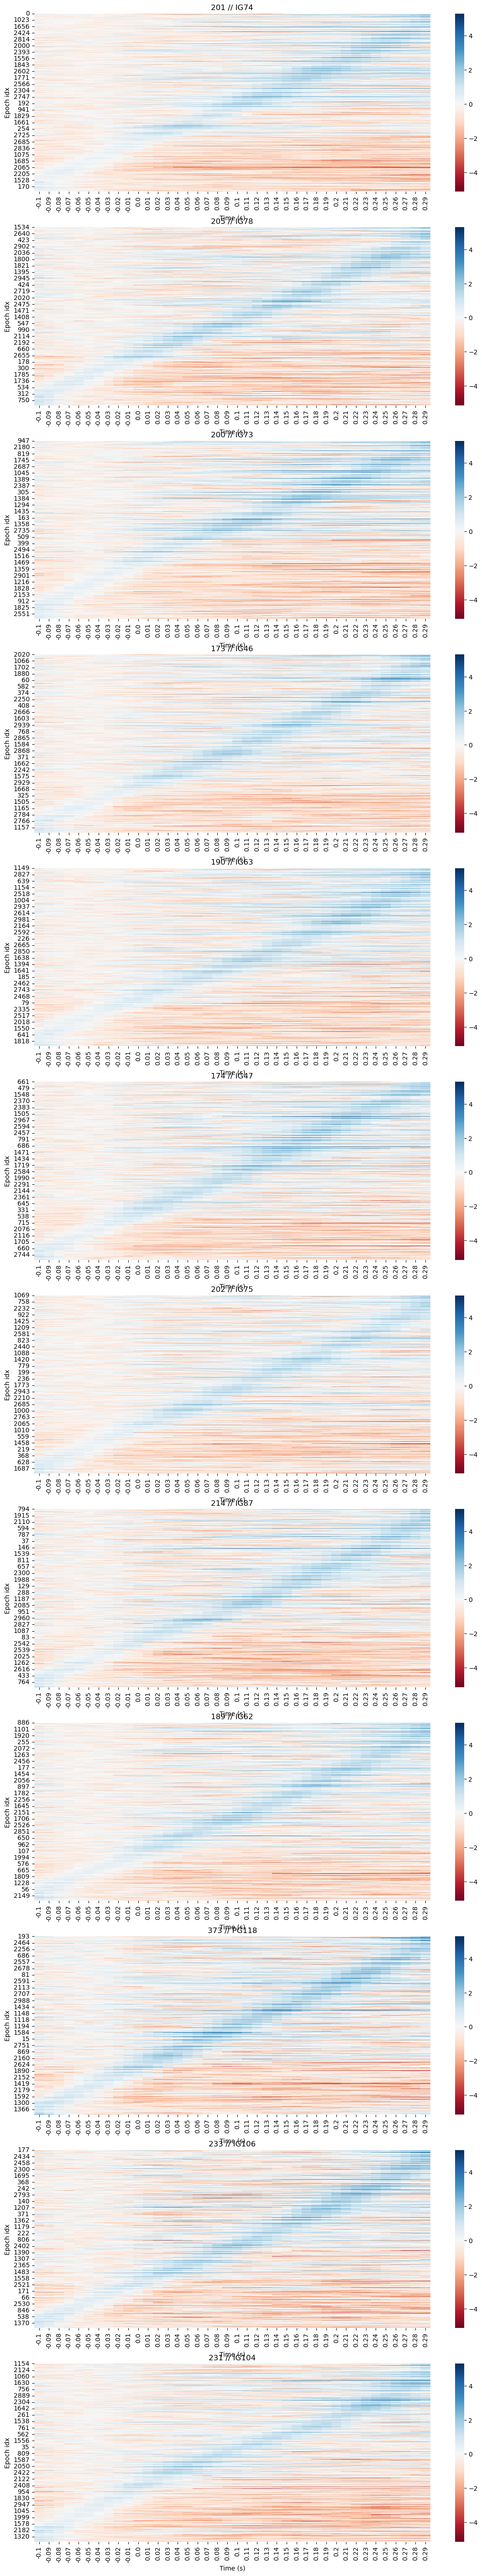

In [ ]:
plot_epoch_raster(word_epochs, electrode_df, order=plot_epoch_electrodes)

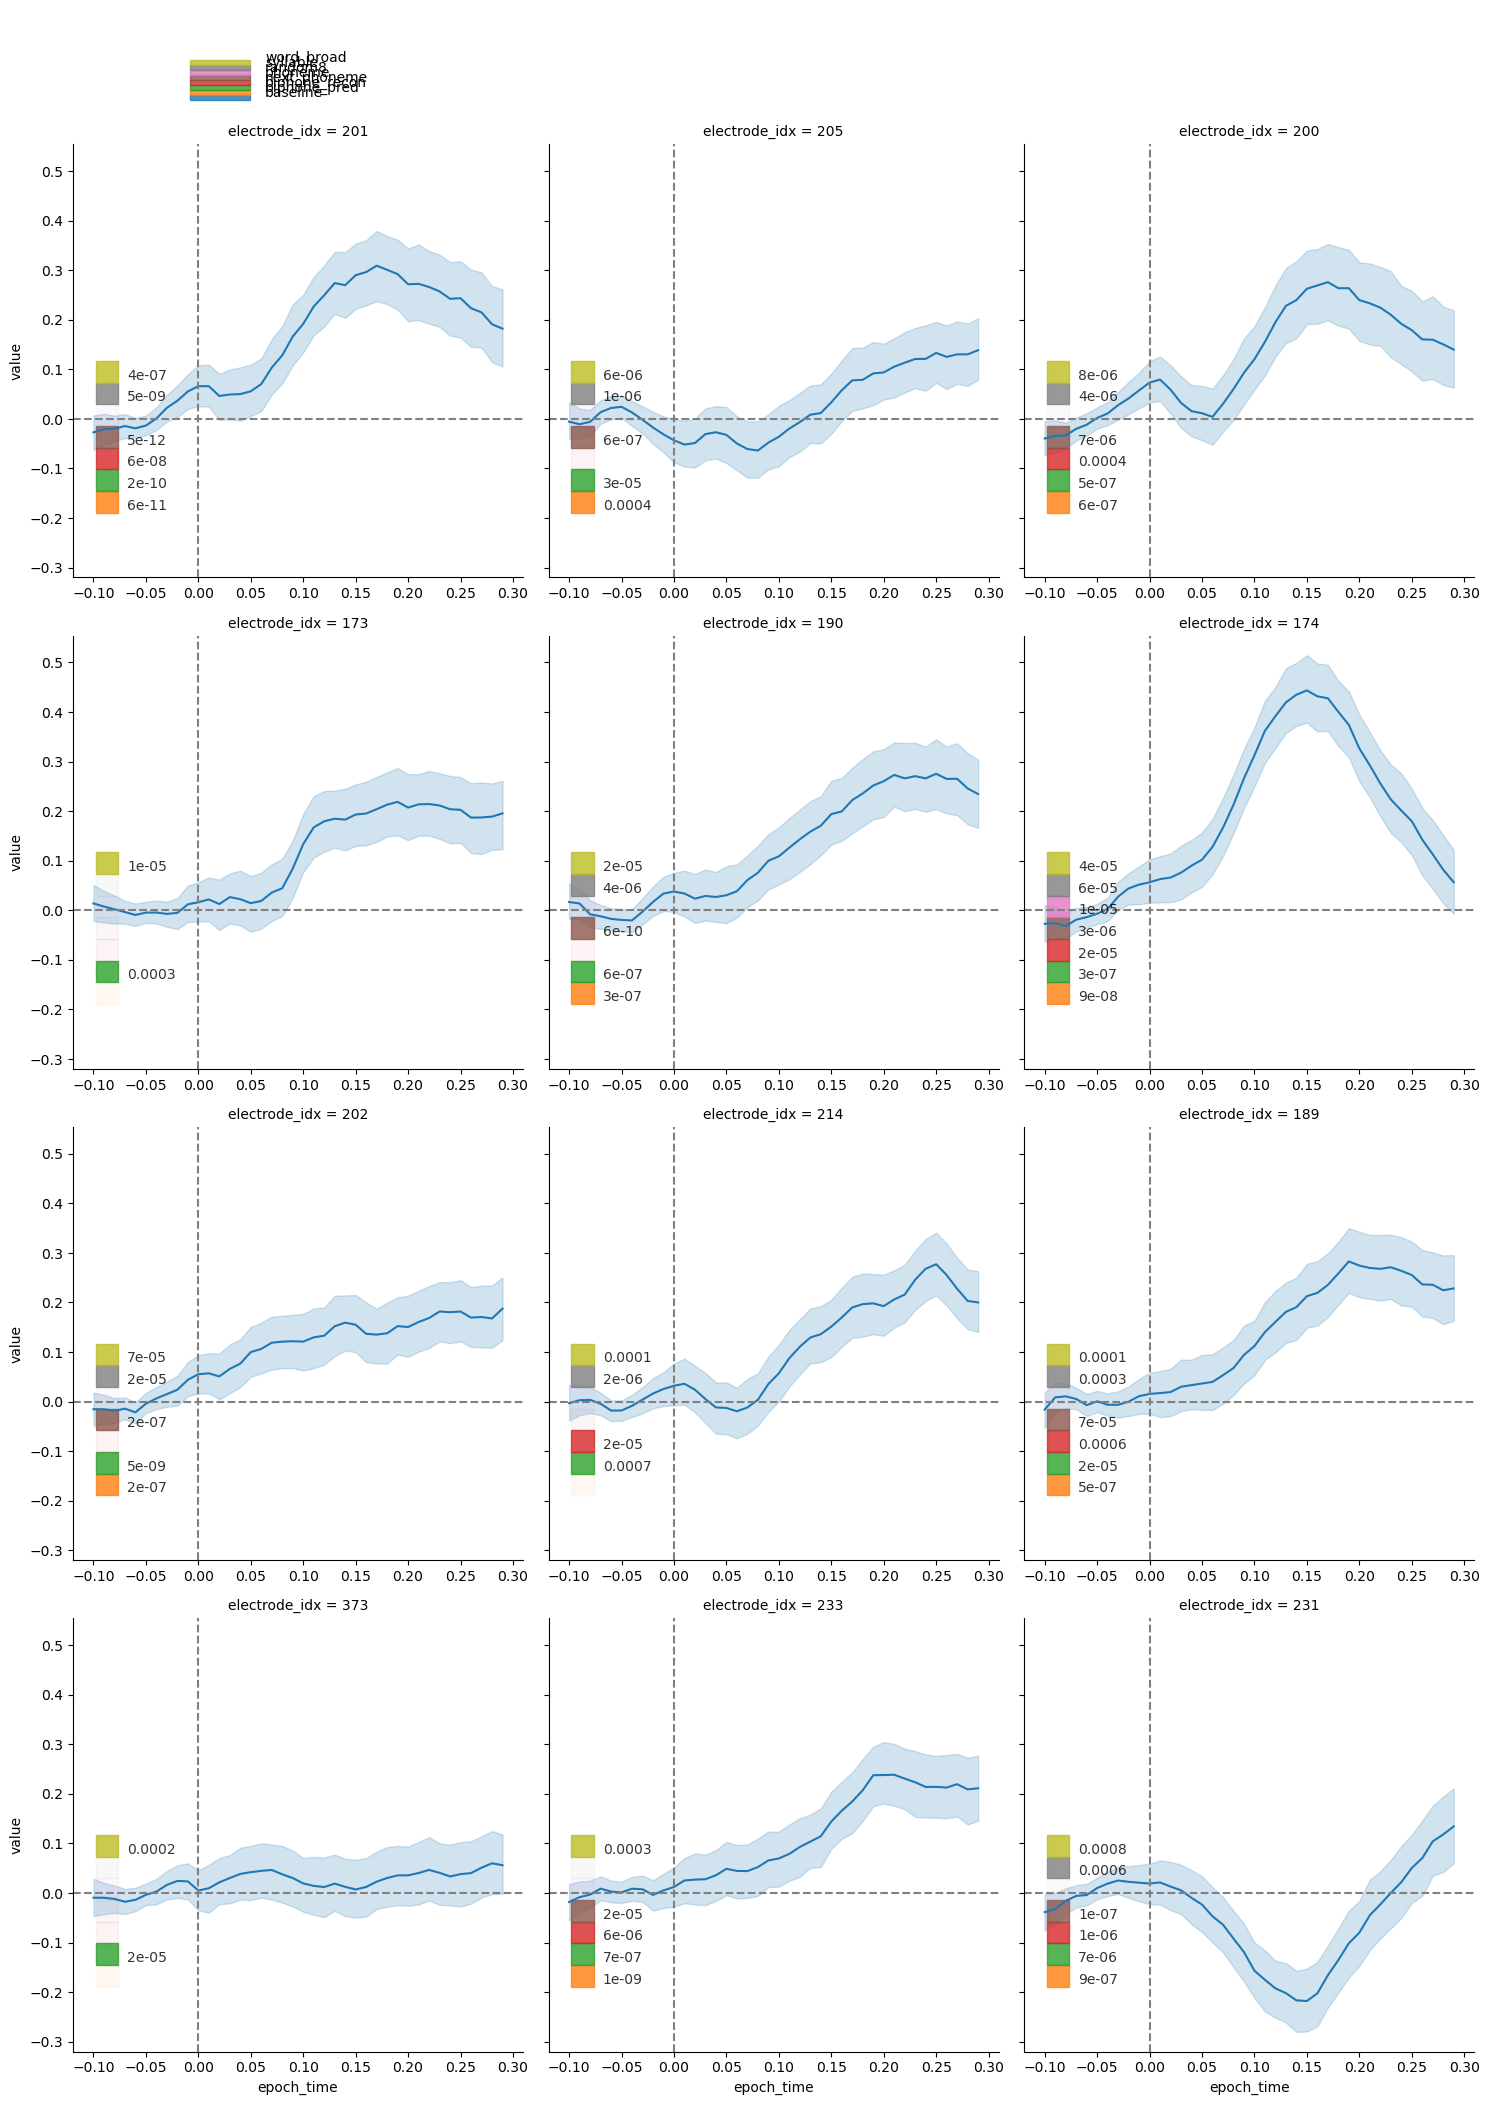

In [ ]:
plot_epochs(word_epochs, col_order=plot_epoch_electrodes)
# TODO add hue by well motivated contrasts between words, break up those error regions into meaningful contrasts